Nous allons dans un premier temps **traiter le jeu de données afin de repérer des variables pertinentes** pour les traitements à venir et **automatiser ces traitements** pour éviter de répéter ces opérations.

## <font color="#00afe6">Sommaire</font>
[1.1. Colonnes et lignes vides / Doublons](#section_1)     
[1.2. Variables redondantes](#section_2)     
[1.3. Les pays de l'analyse](#section_3)     
[1.4. Les catégories de produits](#section_4)          
[1.5. Compléter les valeurs manquantes ou aberrantes](#section_5)     
[1.6. Calcul des Nutri-Scores manquants](#section_6)     

## <font color="#00afe6">1. Nettoyage des données</font>

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

Le jeu de données téléchargé en CSV sur le site [Open Food Facts](https://world.openfoodfacts.org/) est importé dans le Notebook via la méthode `read_csv` de la librairie `pandas`

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

In [3]:
def read_config(file_path='./config.yaml'):
    """Reads configuration file
    Args:
        file_path (str, optional): file path
    Returns:
        dict: Parsed configuration file
    """
    with open(file_path, "r") as f:
        return yaml.safe_load(f)

def get_data(file_path=None, nrows=None):
    """Loads data
    Args:
        file_path (str, optional): file path of dataset
            By default load data set from static web page
        nrows (int, optional): number or rows to loads from dataset
            By default loads all dataset  
    Returns:
        dataframe: output dataframe
    """
    if file_path is None:
        cfg = read_config()
        file_path = cfg['paths']['eng_dataset']
    print("Reading dataset ...")    
    return pd.read_csv(file_path,sep="\t", encoding="utf-8",
                       nrows=nrows, low_memory=False)

if __name__ == "__main__":
    datas = get_data(file_path = "df_withoutduplicatefeatures4.csv")
    print(f"data set shape is {datas.shape}")

Reading dataset ...
data set shape is (2830755, 165)


Affichons à présent quelques lignes au hasard du dataset puis regardons sa `shape`

In [4]:
datas.sample(5)

code                                                url   
2163536  7616700011463  http://world-en.openfoodfacts.org/product/7616...  \
277536   0070784502939  http://world-en.openfoodfacts.org/product/0070...   
1511990  3760299411211  http://world-en.openfoodfacts.org/product/3760...   
988815   2600282024145  http://world-en.openfoodfacts.org/product/2600...   
2063671  6379130182134  http://world-en.openfoodfacts.org/product/6379...   

                                 product_name abbreviated_product_name   
2163536                         Knoblauchbrot                      NaN  \
277536   Tops, milk chocolate peanut clusters                      NaN   
1511990         Pain raisin 250gr rond entier                   Tprr-e   
988815                         Escalope dinde                      NaN   
2063671                    P'tit cake vanille                      NaN   

                          generic_name quantity packaging_en packaging_text   
2163536                            NaN     240g          NaN            NaN  \
277536                             NaN      NaN          NaN            NaN   
1511990  Pain raisin 250gr rond entier    250 g          NaN            NaN   
988815                             NaN      NaN          NaN            NaN   
2063671                            NaN      NaN          NaN            NaN   

                                                    brands   
2163536                                             Migros  \
277536                            Tops,  Tops Markets  Llc   
1511990  Boulangerie de l'hermitage, Pain raisins 250gr...   
988815                                              Auchan   
2063671                                                NaN   

                                             categories_en  ...   
2163536  Plant-based foods and beverages,Plant-based fo...  ...  \
277536                                              Snacks  ...   
1511990                                                NaN  ...   
988815                                                 NaN  ...   
2063671                                                NaN  ...   

        carbon-footprint-from-meat-or-fish_100g nutrition-score-fr_100g   
2163536                                     NaN                    18.0  \
277536                                      NaN                    25.0   
1511990                                     NaN                     NaN   
988815                                      NaN                     NaN   
2063671                                     NaN                     NaN   

        nutrition-score-uk_100g glycemic-index_100g water-hardness_100g   
2163536                     NaN                 NaN                 NaN  \
277536                      NaN                 NaN                 NaN   
1511990                     NaN                 NaN                 NaN   
988815                      NaN                 NaN                 NaN   
2063671                     NaN                 NaN                 NaN   

        choline_100g phylloquinone_100g beta-glucan_100g inositol_100g   
2163536          NaN                NaN              NaN           NaN  \
277536           NaN                NaN              NaN           NaN   
1511990          NaN                NaN              NaN           NaN   
988815           NaN                NaN              NaN           NaN   
2063671          NaN                NaN              NaN           NaN   

        carnitine_100g  
2163536            NaN  
277536             NaN  
1511990            NaN  
988815             NaN  
2063671            NaN  

[5 rows x 165 columns]

In [5]:
print ("Le dataset compte {} lignes et {} variables".format(datas.shape[0], datas.shape[1]))

Le dataset compte 2830755 lignes et 165 variables


### <font color="#ea1c60" id="section_1">1.1. Colonnes et lignes vides / Doublons</font>
Regardons à présent les **variables qui comptent le plus de valeurs null**:

In [6]:
def null_factor(df, tx_threshold=50):
  null_rate = ((datas.isnull().sum() / datas.shape[0])*100).sort_values(ascending=False).reset_index()
  null_rate.columns = ['Variable','Taux_de_Null']
  high_null_rate = null_rate[null_rate.Taux_de_Null >= tx_threshold]
  return high_null_rate

In [7]:
full_null_rate = null_factor(datas, 100)
full_null_rate

Empty DataFrame
Columns: [Variable, Taux_de_Null]
Index: []

Nous allons regarder le taux de remplissage des variables graphiquement et fixer un **seuil de suppression à 25% de taux de remplissage** :

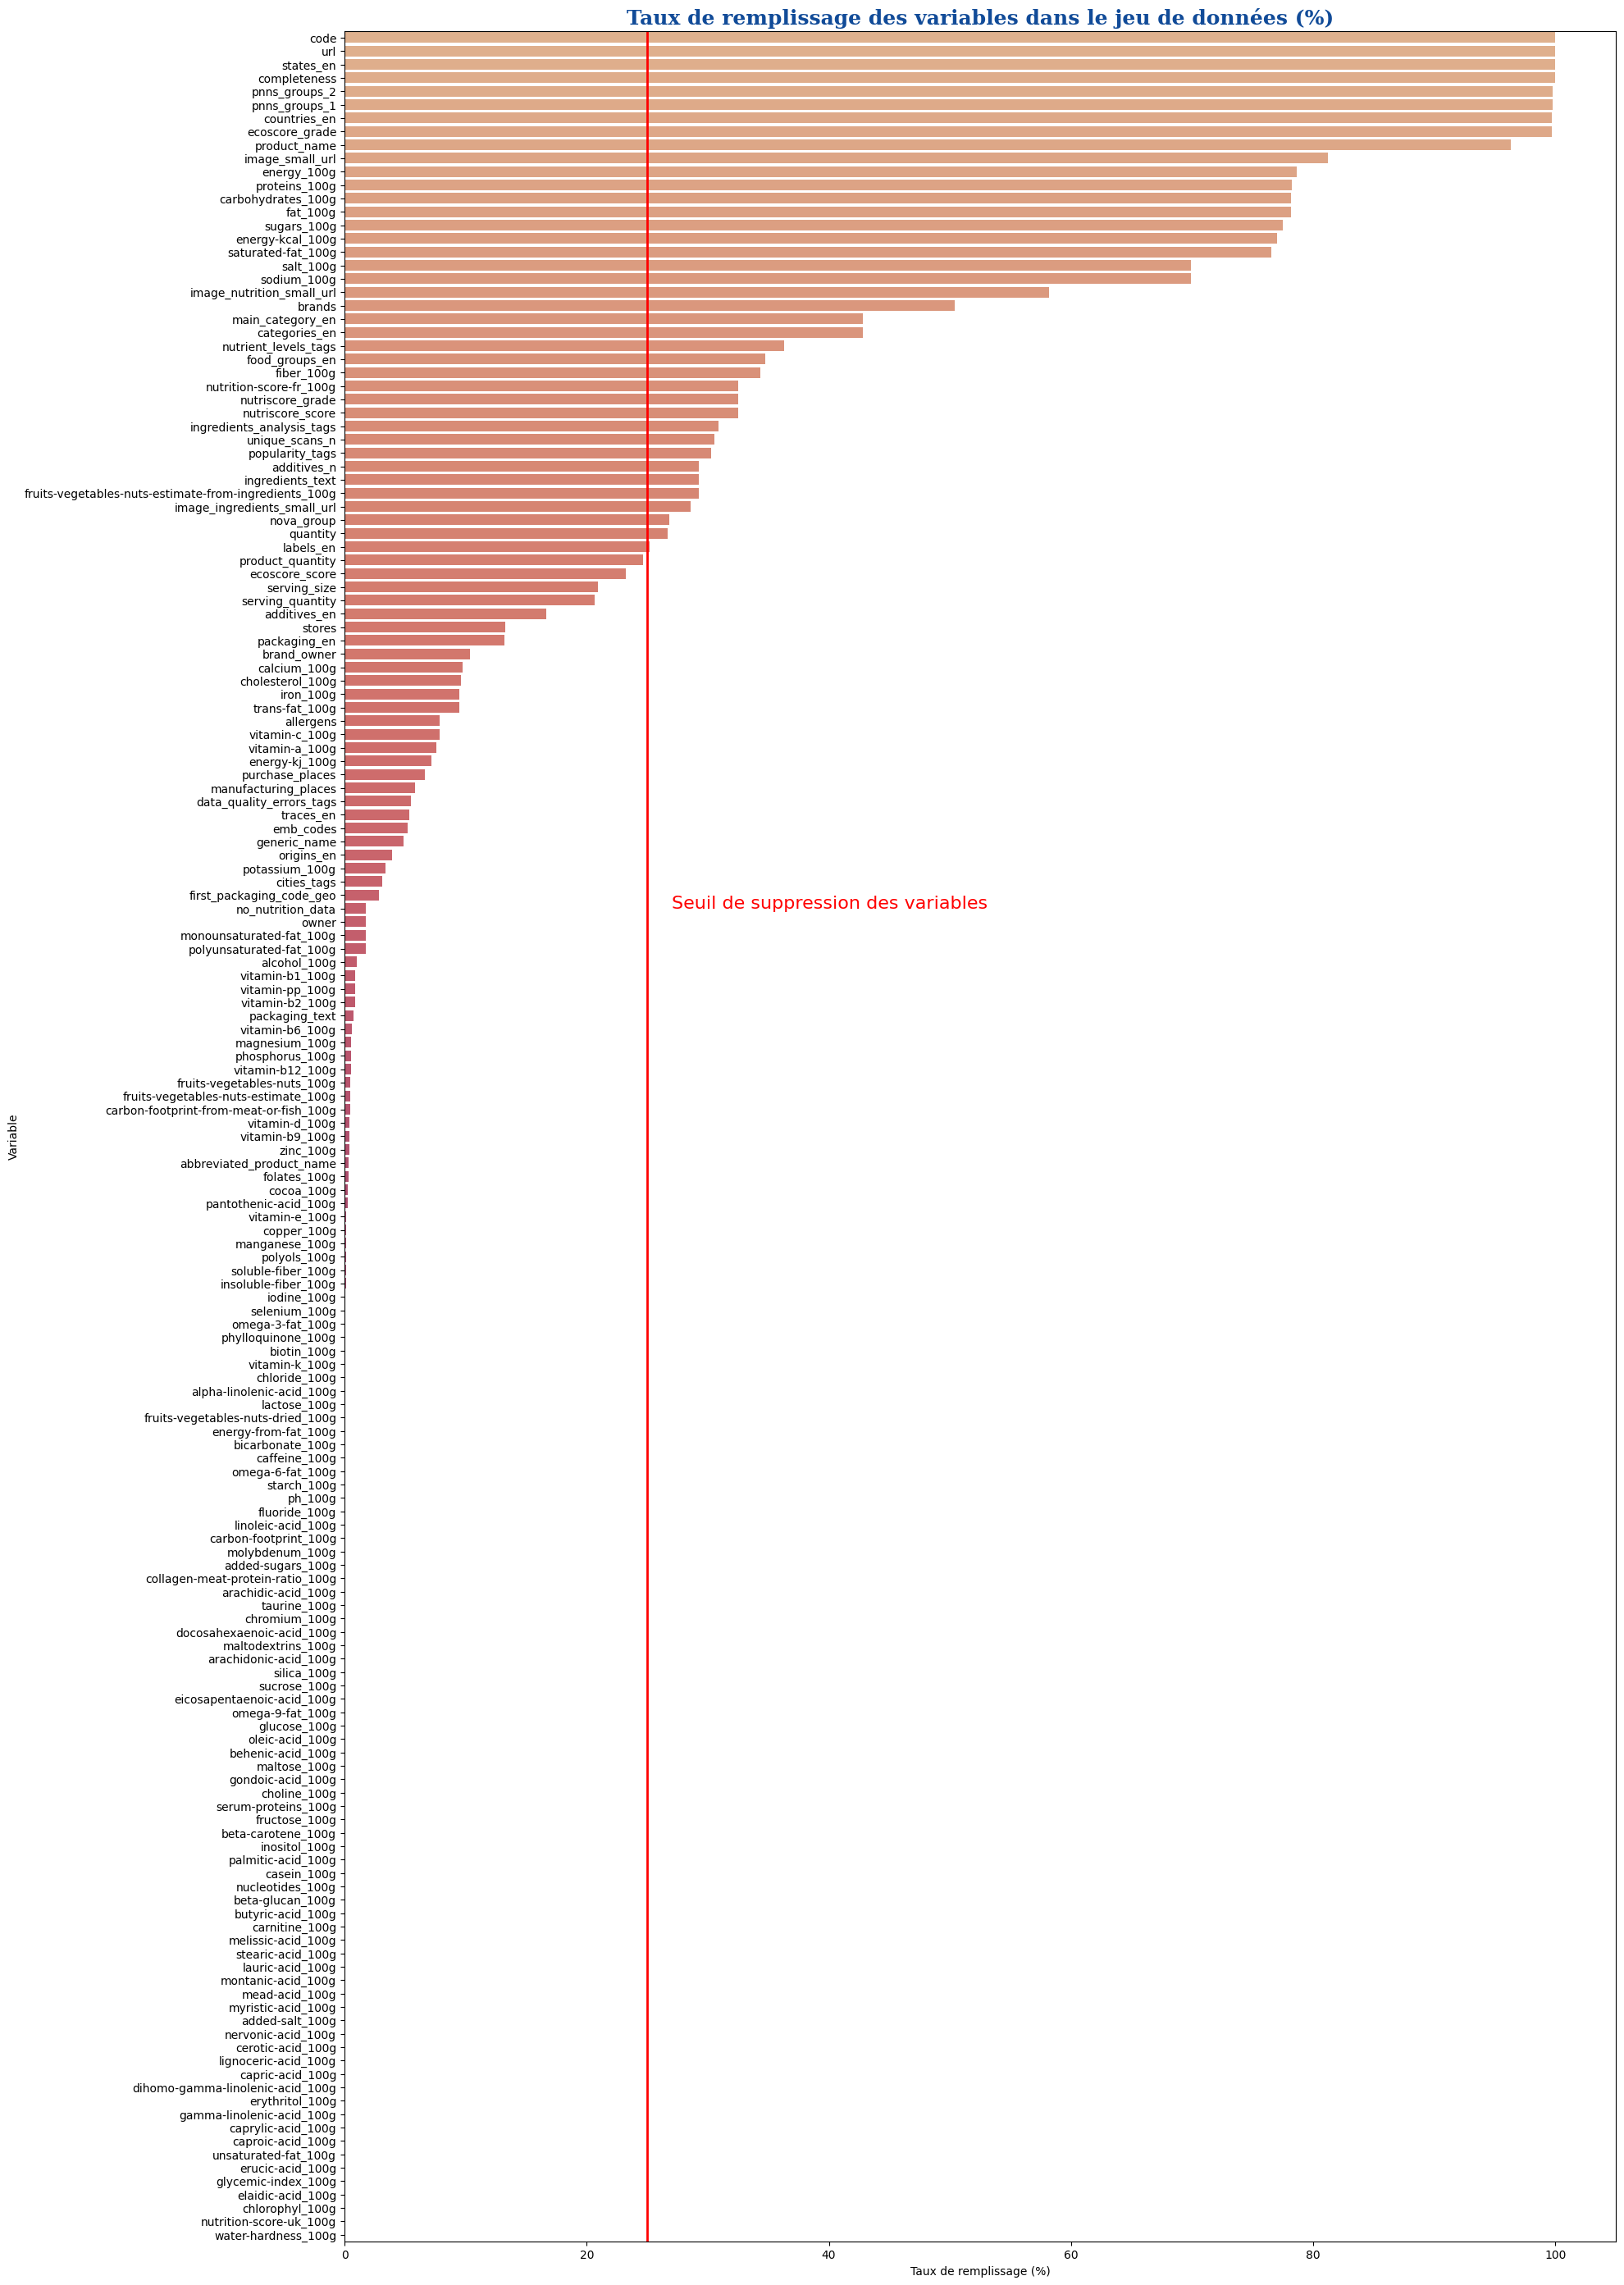

In [8]:
filling_features = null_factor(datas, 0)
filling_features["Taux_de_Null"] = 100-filling_features["Taux_de_Null"]
filling_features = filling_features.sort_values("Taux_de_Null", ascending=False) 

#Seuil de suppression
sup_threshold = 25

fig = plt.figure(figsize=(20, 35))

font_title = {'family': 'serif',
              'color':  '#114b98',
              'weight': 'bold',
              'size': 18,
             }

sns.barplot(x="Taux_de_Null", y="Variable", data=filling_features, palette="flare")
#Seuil pour suppression des varaibles
plt.axvline(x=sup_threshold, linewidth=2, color = 'r')
plt.text(sup_threshold+2, 65, 'Seuil de suppression des variables', fontsize = 16, color = 'r')

plt.title("Taux de remplissage des variables dans le jeu de données (%)", fontdict=font_title)
plt.xlabel("Taux de remplissage (%)")
plt.show()

In [9]:
#Liste des variables à conserver
features_to_conserve = list(filling_features.loc[filling_features['Taux_de_Null']>=sup_threshold, 'Variable'].values)
#Liste des variables supprimées
deleted_features = list(filling_features.loc[filling_features['Taux_de_Null']<sup_threshold, 'Variable'].values)

#Nouveau Dataset avec les variables conservées
datas = datas[features_to_conserve]
datas.sample(5)

code                                                url   
2575618  8435382802126  http://world-en.openfoodfacts.org/product/8435...  \
665813   0812542005043  http://world-en.openfoodfacts.org/product/0812...   
2079453  6949656160048  http://world-en.openfoodfacts.org/product/6949...   
2815975       95502335  http://world-en.openfoodfacts.org/product/9550...   
1668368  4062300308497  http://world-en.openfoodfacts.org/product/4062...   

                                                 states_en  completeness   
2575618  To be completed,Nutrition facts completed,Ingr...        0.5750  \
665813   To be completed,Nutrition facts completed,Ingr...        0.5500   
2079453  To be completed,Nutrition facts completed,Ingr...        0.2750   
2815975  To be completed,Nutrition facts completed,Ingr...        0.4625   
1668368  To be completed,Nutrition facts completed,Ingr...        0.7875   

        pnns_groups_2            pnns_groups_1         countries_en   
2575618        Cheese  Milk and dairy products                Spain  \
665813        unknown                  unknown        Canada,France   
2079453       unknown                  unknown                Spain   
2815975       unknown                  unknown               France   
1668368        Fruits    Fruits and vegetables  Germany,Switzerland   

        ecoscore_grade          product_name   
2575618              d         Queso maasdam  \
665813         unknown   Kernels All Dressed   
2079453        unknown   Noodles sabor pollo   
2815975        unknown       Thon Pimenté ¡¡   
1668368              b  Kiwi in Birne Banane   

                                           image_small_url  ...   
2575618  https://images.openfoodfacts.org/images/produc...  ...  \
665813                                                 NaN  ...   
2079453  https://images.openfoodfacts.org/images/produc...  ...   
2815975                                                NaN  ...   
1668368  https://images.openfoodfacts.org/images/produc...  ...   

                                 ingredients_analysis_tags  unique_scans_n   
2575618                                                NaN             NaN  \
665813                                                 NaN             NaN   
2079453                                                NaN             NaN   
2815975    en:palm-oil-free,en:non-vegan,en:non-vegetarian             NaN   
1668368  en:palm-oil-content-unknown,en:vegan-status-un...             2.0   

                                           popularity_tags  additives_n   
2575618                                                NaN          NaN  \
665813                                                 NaN          NaN   
2079453                                                NaN          NaN   
2815975                                                NaN          1.0   
1668368  at-least-5-scans-2019,top-75-percent-scans-201...          0.0   

                                          ingredients_text   
2575618                                                NaN  \
665813                                                 NaN   
2079453                                                NaN   
2815975  'Ingredients: Tuna, Water, Soy Bean Oil, Chill...   
1668368  100% Fruits* (poires* 67%, bananes* 20%, kiwi*...   

         fruits-vegetables-nuts-estimate-from-ingredients_100g   
2575618                                                NaN      \
665813                                                 NaN       
2079453                                                NaN       
2815975                                                0.0       
1668368                                              100.0       

                               image_ingredients_small_url  nova_group   
2575618                                                NaN         NaN  \
665813                                                 NaN         NaN   
2079453                                                NaN         

155 features sur 184 ont un taux de valeurs nulles supérieur à 50%, ce qui représente une très grosse part de données manquantes. **La majeure partie de ces variables ne peuvent pas être recalculées** puisqu'il s'agit de mesures physico-chimiques directes sur les produits.

Il reste à présent 50 features dans notre dataset. Pour la suite des analyses, nous aurons besoin d'un minimum d'informations sur **les nutriments** des produits. Ces données sont **suffixées avec** `_100g`. Nous allons donc **conserver les lignes pour lesquelles au moins une de ces features est complétée** :

In [10]:
def search_componant(df, suffix='_100g'):
  componant = []
  for col in df.columns:
      if '_100g' in col: componant.append(col)
  df_subset_columns = df[componant]
  return df_subset_columns

In [11]:
df_subset_nutients = search_componant(datas,'_100g')
df_subset_nutients.head()

energy_100g  proteins_100g  carbohydrates_100g  fat_100g  sugars_100g   
0          NaN            NaN                 NaN       NaN          NaN  \
1        690.0            1.5                65.0       2.0         12.6   
2          NaN            2.7                 9.8       1.4          9.8   
3        238.0           10.0                 3.9       0.2          3.9   
4       1569.0            7.8                70.1       7.0         15.0   

   energy-kcal_100g  saturated-fat_100g  salt_100g  sodium_100g  fiber_100g   
0               NaN                 NaN        NaN          NaN         NaN  \
1             165.0                2.00        NaN          NaN         3.0   
2               NaN                0.90       0.10        0.040         NaN   
3              57.0                0.10       0.09        0.036         NaN   
4             375.0                3.08       1.40        0.560         NaN   

   nutrition-score-fr_100g   
0                      NaN  \
1                      NaN   
2                      NaN   
3                     -5.0   
4                      NaN   

   fruits-vegetables-nuts-estimate-from-ingredients_100g  
0                                                NaN      
1                                                NaN      
2                                                0.0      
3                                                NaN      
4                                                NaN

In [12]:
print('Lignes nutriments (_100g) vides: {}'.format(df_subset_nutients.isnull().all(axis=1).sum()))

Lignes nutriments (_100g) vides: 476844


In [13]:
datas = datas[df_subset_nutients.notnull().any(axis=1)]
datas.shape

(2353911, 39)

Notre jeu de données est à présent débarassé des lignes et colonnes peu complétées. Nous allons à présent **rechercher et supprimer les doublons**.

In [14]:
# Suppression des doublons en fonction du code
datas.drop_duplicates(subset ="code", keep = 'last', inplace=True)

In [15]:
datas[(datas["product_name"].isnull()==False) 
      & (datas["brands"].isnull()==False)].groupby(by=["product_name","brands"])["code"].nunique().sort_values(ascending=False)

product_name                 brands                 
Burger vegetariana           Bonarea                    305
Filet de poulet              La Nouvelle Agriculture    218
Burger vegana                Bonarea                    205
Finísimo de pechuga de pavo  Bonarea                    155
Filet de poulet              Le Gaulois                 146
                                                       ... 
Galette raclette             Tre Galette                  1
Galette raclettes            Hiruak                       1
Galette riz Chocolat Noir    Gerblé                       1
Galette riz choco orange     Gerblé                       1
🤬                            🤬                            1
Name: code, Length: 1131983, dtype: int64

In [16]:
datas = datas[(datas["product_name"]!="🤬") 
              & (datas["brands"]!="🤬")]

In [17]:
# Suppression des doublons sur marque et produit en conservant les valeurs nulles
datas = datas[(~datas.duplicated(["product_name","brands"],keep="last")) 
      | ((datas['product_name'].isnull()) & (datas['brands'].isnull()))]

In [18]:
datas.shape

(1875175, 39)

### <font color="#ea1c60" id="section_2">1.2. Variables redondantes</font>

Certaines variables dans le dataset sont en réalité des variables redondantes. C'est par exemple le cas des variables suffixées par `_tags` ou `_en` qui ne font que reprendre d'autres features traduites ou simplifiées.

Nous les avons donc supprimé au prealable

On remarque dans ces quelques exemples que les variables sont bien redondantes. Nous allons donc, lorsque la colonne suffixée `_en` existe, supprimer toutes les autres colonnes identiques non suffixées ou contenant `_tags` :

In [19]:
def search_redundant_col(df):
  redundant_columns = []
  for col in df.columns:
    if "_en" in col:
      en = col.replace('_en','')
      tags = col.replace('_en','_tags')
      print("{:<20} 'Sans suffixe' -> {} ; 'Suffixe _tags' -> {}".format(col,
                                                                        en in df.columns, tags in df.columns))
      if en in df.columns : 
        redundant_columns.append(en)
      if tags in df.columns : 
        redundant_columns.append(tags)
  
    if '_tags' in col:
      tags_2 = col.replace('_tags','')
      print("{:<20} 'Suffixe _tags' -> {} ;".format(tags_2, tags_2 in df.columns))
      if tags_2 in df.columns :
        redundant_columns.append(col)

  return redundant_columns

In [20]:
datas.drop(search_redundant_col(datas), axis=1, inplace=True)

states_en            'Sans suffixe' -> False ; 'Suffixe _tags' -> False
countries_en         'Sans suffixe' -> False ; 'Suffixe _tags' -> False
main_category_en     'Sans suffixe' -> False ; 'Suffixe _tags' -> False
categories_en        'Sans suffixe' -> False ; 'Suffixe _tags' -> False
nutrient_levels      'Suffixe _tags' -> False ;
food_groups_en       'Sans suffixe' -> False ; 'Suffixe _tags' -> False
ingredients_analysis 'Suffixe _tags' -> False ;
popularity           'Suffixe _tags' -> False ;
labels_en            'Sans suffixe' -> False ; 'Suffixe _tags' -> False


**Les dates également comportent une certaine redondance**. Entre les timestamp et les dates au format "yyyy-mm-dd", il est nécessaire d'en éliminer :

In [21]:
#datas['created_datetime'] = pd.to_datetime(datas['created_t'], unit='s')
#datas['last_modified_datetime'] = pd.to_datetime(datas['last_modified_t'], unit='s')
#datas = datas.drop(['created_t','last_modified_t'], axis=1)
#datas.head()

Nous pouvons à présent regarder la **distribution des contributions par année** :

In [22]:
add_per_year = datas[['created_datetime', 'code']].groupby(by=datas['created_datetime'].dt.year).nunique()

fig=plt.figure(figsize=(12,8))

sns.set_style("whitegrid")
sns.barplot(data=add_per_year, x=add_per_year.index, y='code', color='#00afe6')

plt.title("Evolution des créations de produits dans la base par année", fontdict=font_title)
plt.xlabel("Année de création")
plt.ylabel("Nombre de créations")
plt.show()

KeyError: "['created_datetime'] not in index"

Les années de 2012 à 2016 sont visiblement bien moins représentées que les années 2017 à 2019. La mise en place du Nutri-Score a été votée dans le cadre de la **loi Santé de 2016**.

In [23]:
datas.shape

(1875175, 39)

A présent, notre dataset compte 40 variables qui ne contienent plus de redondance et 1 124 710 lignes. Nous allons maintenant nous intéresser à une variable importante : le pays.

### <font color="#ea1c60" id="section_3">1.3. Les pays de l'analyse</font>

Regardons tout d'abord le nombre de pays représentés *(s'il est trop élevé, c'est que des erreurs existent)*

In [24]:
countries = datas.groupby(by="countries_en").nunique()

In [25]:
countries[['code']].head()

code
countries_en                           
123456789                             1
Afghanistan                          15
Afghanistan,Belgium,France            2
Afghanistan,Finland,France,Sweden     1
Afghanistan,France                  115

Plusieurs pays sont regroupés dans la même variable, nous allons devoir effectuer un split du texte pour visualiser tout nos pays :

In [26]:
def split_words(df, column = 'countries_en'):
  list_words = set()
  for word in df[column].str.split(','):
    if isinstance(word, float):
      continue
    list_words = set().union(word, list_words)
  return list(list_words)

In [27]:
#Liste contenant tous les pays du jeu de données (bons ou mauvais)
list_countries = split_words(datas, 'countries_en')

In [28]:
print("Nombre de pays représentés : {}".format(len(list_countries)))

Nombre de pays représentés : 882


Nous avons traiter les pays pour garder anglais.

### <font color="#ea1c60" id="section_4">1.4. Les catégories de produits</font>

Intéressons nous à présent à la catégorisation des produits. 4 variables représentent cette catégorisation de manière plus ou moins précise : `categories_en`, `main_category_en`, `pnns_groups_1`, `pnns_groups_2`.

In [29]:
datas[['categories_en','pnns_groups_1','pnns_groups_2','main_category_en',]].sample(10)

categories_en   
829038   Plant-based foods and beverages,Beverages,Plan...  \
712093   Snacks,Sweet snacks,Cocoa and its products,Con...   
2392476                                                NaN   
2419644  Plant-based foods and beverages,Plant-based fo...   
271424               Desserts,Frozen foods,Frozen desserts   
2566675  Plant-based foods and beverages,Plant-based fo...   
1871063                                                NaN   
1173700  Plant-based foods and beverages,Plant-based fo...   
1187285  Snacks,Sweet snacks,Biscuits and cakes,Biscuit...   
2180924  Dairies,Fermented foods,Fermented milk product...   

                   pnns_groups_1        pnns_groups_2    main_category_en  
829038                 Beverages  Sweetened beverages   Apple soft drinks  
712093             Sugary snacks               Sweets   Chocolate candies  
2392476                  unknown              unknown                 NaN  
2419644          Composite foods       One-dish meals            Risottos  
271424                   unknown              unknown     Frozen desserts  
2566675    Fruits and vegetables           Vegetables     White asparagus  
1871063                  unknown              unknown                 NaN  
1173700     Cereals and potatoes    Breakfast cereals   Mueslis with nuts  
1187285            Sugary snacks   Biscuits and cakes  Chocolate biscuits  
2180924  Milk and dairy products               Cheese             Cheeses

Nous allons regarder le **nombre total de catégories représentées** :

In [30]:
categories = split_words(df = datas, column = 'categories_en')
print("{} catégories sont représentées dans le jeu de données.".format(len(categories)))

42448 catégories sont représentées dans le jeu de données.


Ici également, nous allons regarder les **catégories les plus représentées**, après avoir remplacé les valeurs nulles et complété les valeurs inconnues des pnns avec la catégorie principale :

In [31]:
datas['categories_en'] = np.where((datas['categories_en'].isnull()==True), "unknown", 
                                 np.where(datas['categories_en'] == "", "unknown", datas['categories_en']))
datas['main_category_en'] = np.where((datas['main_category_en'].isnull()==True), "unknown", 
                                 np.where(datas['main_category_en'] == "", "unknown", datas['main_category_en']))
datas['pnns_groups_1'] = np.where((datas['pnns_groups_1'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_1'] == "", "unknown", datas['pnns_groups_1']))
datas['pnns_groups_2'] = np.where((datas['pnns_groups_2'].isnull()==True), "unknown", 
                                 np.where(datas['pnns_groups_2'] == "", "unknown", datas['pnns_groups_2']))

In [32]:
def top_words(df, column="countries_en", nb_top=10):
    count_keyword = dict()
    df_col = df[column].to_frame(name=column)
    for index, col in df_col.iterrows():
        if isinstance(col[column], float):
            continue
        for word in col[column].split(','):
            if word in count_keyword.keys():
                count_keyword[word] += 1
            else:
                count_keyword[word] = 1

    keyword_top = []
    for k,v in count_keyword.items():
        keyword_top.append([k,v])
    keyword_top.sort(key = lambda x:x[1], reverse = True)

    return keyword_top[:nb_top]

In [33]:
df_top_categories = pd.DataFrame(top_words(df=datas, column="categories_en", nb_top=10), 
                                 columns=["Keyword","count"])
df_top_categories

Keyword   count
0                          unknown  965580
1  Plant-based foods and beverages  286527
2                Plant-based foods  245166
3                           Snacks  187076
4                     Sweet snacks  135551
5                        Beverages  101282
6             Cereals and potatoes   92114
7                          Dairies   89357
8         Meats and their products   72115
9                  Fermented foods   69407

Il existe donc également une grande disparité dans les catégories représentées et les "unknown", les catégories inconnues l'emportent. 

Pour une meilleure visualisation, nous allons représenter le top 100 des catégories dans un nuage de mots grâce à la librairie `WordCloud` :

In [34]:
from wordcloud import WordCloud

def plot_world_cloud(df=datas,column="categories_en",nb_top=100):
  fig = plt.figure(1, figsize=(20,15))
  ax1 = fig.add_subplot(1,1,1)

  words = dict()
  trunc_occurences = top_words(df=df, column=column, nb_top=nb_top)
  for s in trunc_occurences:
    words[s[0]] = s[1]

  word_cloud = WordCloud(width=900,height=500, normalize_plurals=False,
                        background_color="white")
  word_cloud.generate_from_frequencies(words)
  ax1.imshow(word_cloud, interpolation="bilinear")
  ax1.axis('off')
  plt.title("Nuage de mots des {} meilleures {}\n".format(nb_top, column), fontsize=22)
  plt.show()


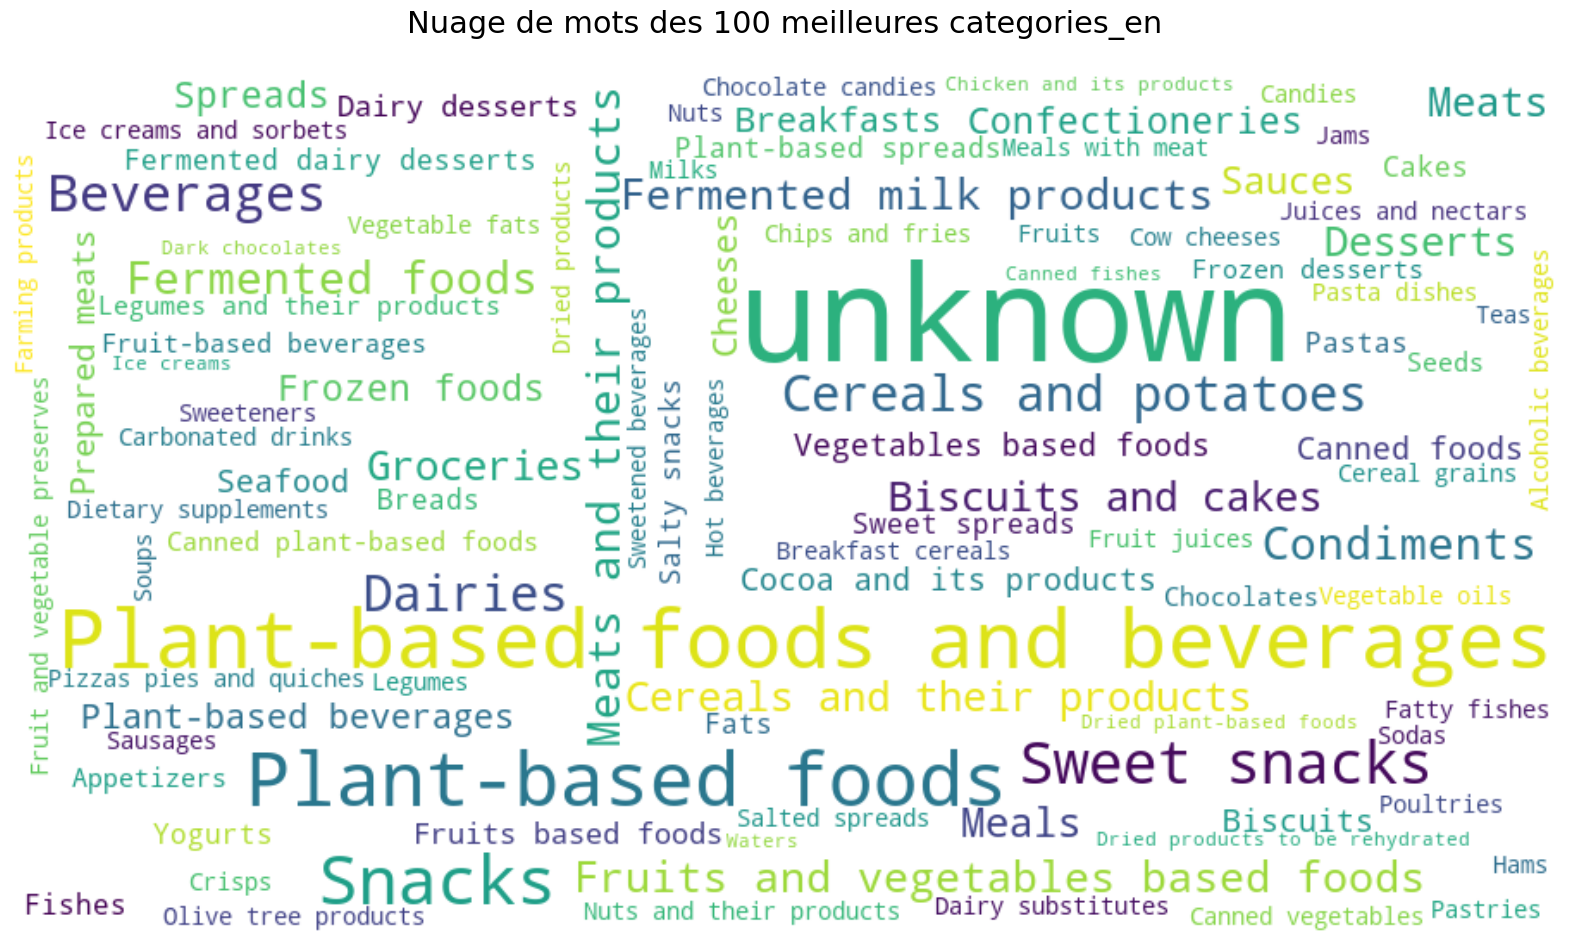

In [35]:
plot_world_cloud(df=datas,column="categories_en",nb_top=100)

Passons à présent aux variables `pnns_groups_1` et `pnns_groups_2` qui nous apporteront des informations plus précises :

In [36]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

12 catégories sont représentées dans la variable pnns_group_1.
41 catégories sont représentées dans la variable pnns_group_2.


In [37]:
pnns_groups_1

['Salty snacks',
 'Fat and sauces',
 'Sugary snacks',
 'Fish Meat Eggs',
 'Fruits and vegetables',
 'Cereals and potatoes',
 'sugary-snacks',
 'unknown',
 'Beverages',
 'Milk and dairy products',
 'Alcoholic beverages',
 'Composite foods']

On voit ici que certaines catégories sont présentes plusieurs fois mais orthographiées différement :
- 'Cereals and potatoes' et 'cereals-and-potatoes'
- 'fruits-and-vegetables' et 'Fruits and vegetables'
- ...

Nous allons donc corriger le problème en passant le texte en miniscule et en remplaçant les caractères spéciaux par un espace :

In [38]:
datas["pnns_groups_1"] = datas["pnns_groups_1"].str.lower().str.replace('-', ' ')

In [39]:
pnns_groups_1 = split_words(df = datas, column = 'pnns_groups_1')
print("{} catégories sont représentées dans la variable pnns_group_1.".format(len(pnns_groups_1)))
print(pnns_groups_1)

11 catégories sont représentées dans la variable pnns_group_1.
['fruits and vegetables', 'cereals and potatoes', 'alcoholic beverages', 'composite foods', 'salty snacks', 'sugary snacks', 'fat and sauces', 'unknown', 'fish meat eggs', 'milk and dairy products', 'beverages']


In [40]:
pnns_groups_2

['Sandwiches',
 'Bread',
 'Fruit juices',
 'Unsweetened beverages',
 'Fruits',
 'Fats',
 'Dressings and sauces',
 'Vegetables',
 'Chocolate products',
 'Milk and yogurt',
 'Dried fruits',
 'unknown',
 'Waters and flavored waters',
 'pastries',
 'Cheese',
 'Cereals',
 'One-dish meals',
 'Ice cream',
 'Dairy desserts',
 'Pastries',
 'Soups',
 'Pizza pies and quiches',
 'Meat',
 'Alcoholic beverages',
 'Nuts',
 'Legumes',
 'Teas and herbal teas and coffees',
 'Salty and fatty products',
 'Processed meat',
 'Fruit nectars',
 'Fish and seafood',
 'Sweetened beverages',
 'Eggs',
 'Breakfast cereals',
 'Artificially sweetened beverages',
 'Potatoes',
 'Appetizers',
 'Biscuits and cakes',
 'Offals',
 'Sweets',
 'Plant-based milk substitutes']

In [41]:
datas["pnns_groups_2"] = datas["pnns_groups_2"].str.lower().str.replace('-', ' ').replace('pizza pies and quiche','pizza pies and quiches')
pnns_groups_2 = split_words(df = datas, column = 'pnns_groups_2')
print("{} catégories sont représentées dans la variable pnns_group_2.".format(len(pnns_groups_2)))

40 catégories sont représentées dans la variable pnns_group_2.


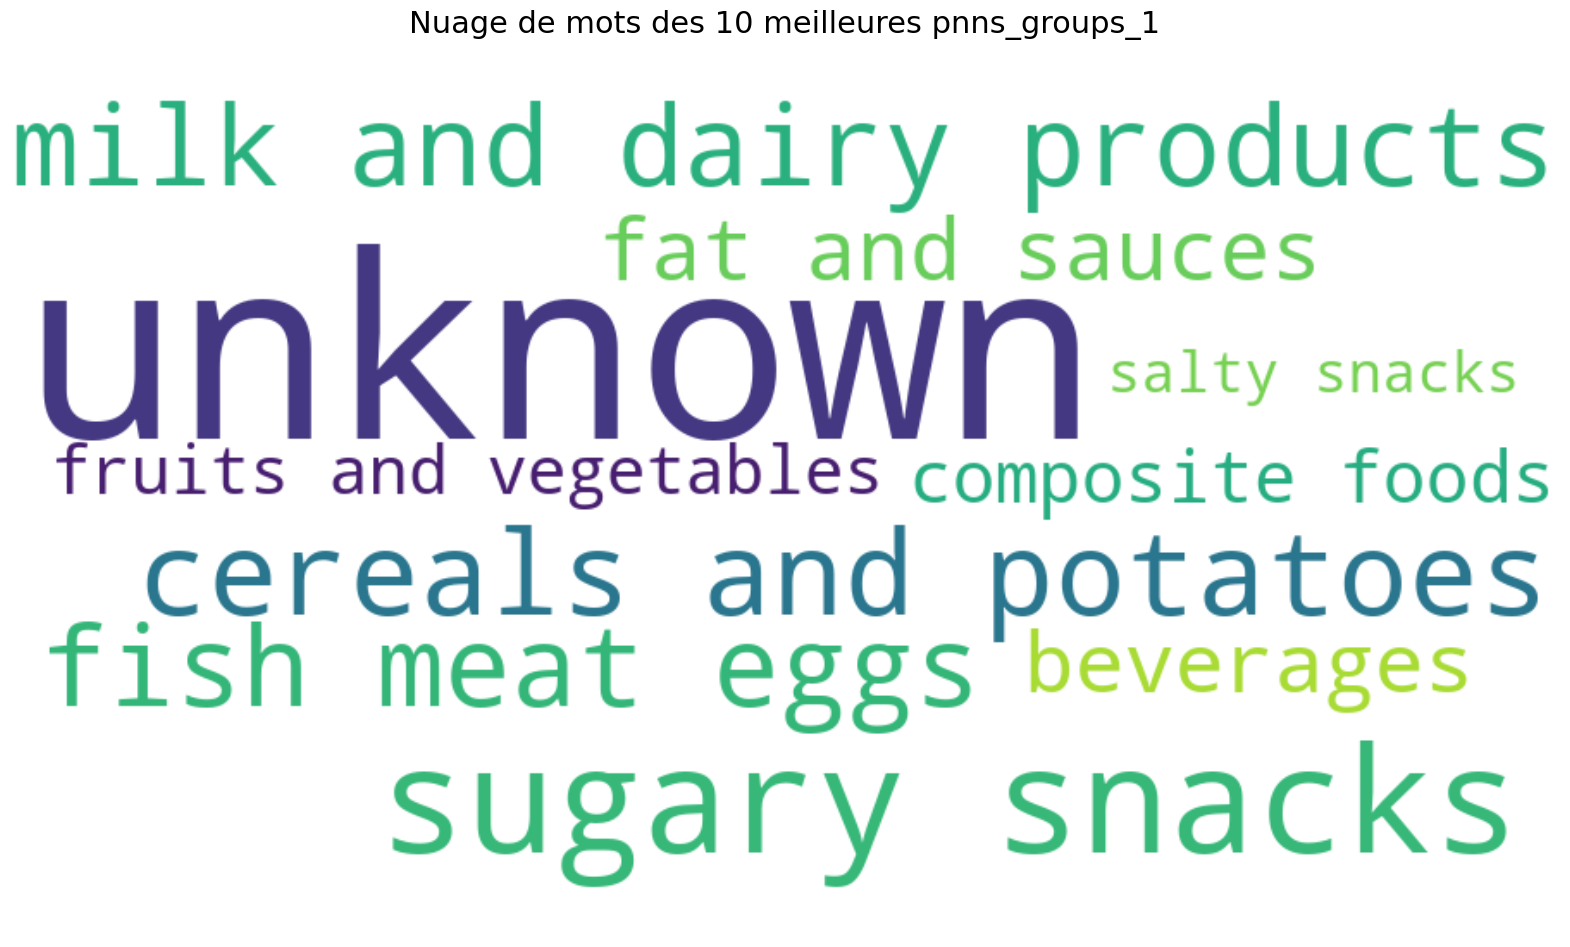

In [42]:
plot_world_cloud(df=datas,column="pnns_groups_1",nb_top=10)

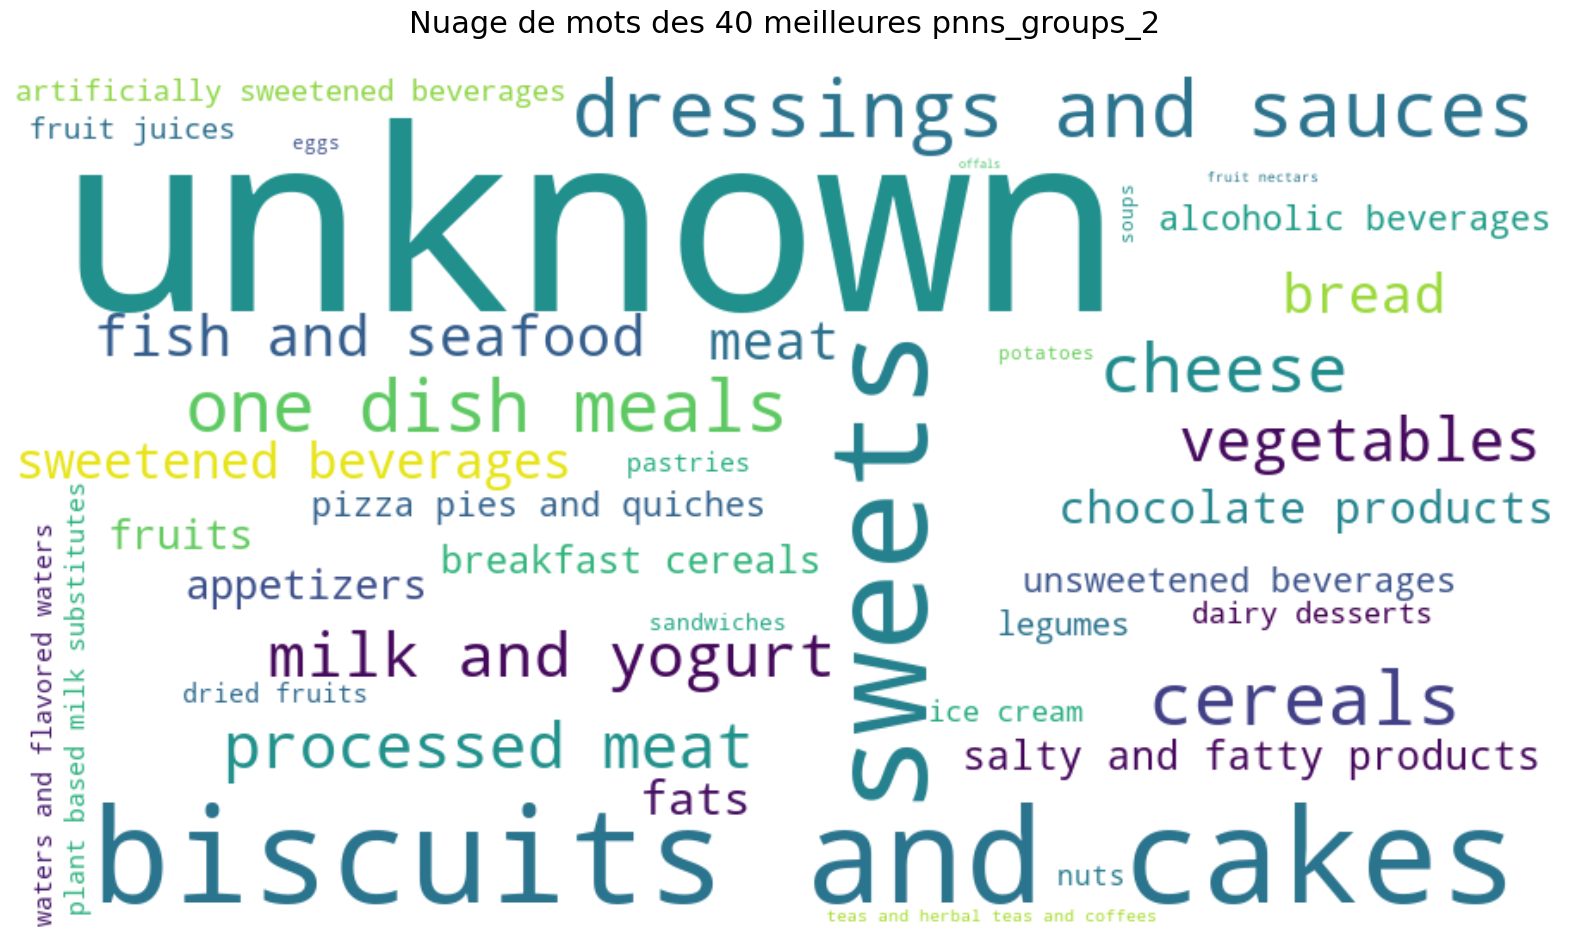

In [43]:
plot_world_cloud(df=datas,column="pnns_groups_2",nb_top=len(pnns_groups_2))

In [44]:
datas.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1875175 entries, 1 to 2830754
Data columns (total 39 columns):
 #   Column                                                 Dtype  
---  ------                                                 -----  
 0   code                                                   object 
 1   url                                                    object 
 2   states_en                                              object 
 3   completeness                                           float64
 4   pnns_groups_2                                          object 
 5   pnns_groups_1                                          object 
 6   countries_en                                           object 
 7   ecoscore_grade                                         object 
 8   product_name                                           object 
 9   image_small_url                                        object 
 10  energy_100g                                            float64
 11  pro

### <font color="#ea1c60" id="section_5">1.5. Compléter les valeurs manquantes ou aberrantes</font>

Le jeu de données est nettoyé mais comme le montre les informations ci-dessus, il reste un grand nombre de valeurs manquantes qu'il va falloir compléter mais également des outliers à identifier.

Regardons dans un premier temps une rapide description du Dataset :

In [45]:
datas.describe()

completeness   energy_100g  proteins_100g  carbohydrates_100g   
count  1.875173e+06  1.767198e+06   1.756602e+06        1.754998e+06  \
mean   4.800630e-01  1.242332e+40   8.847981e+00        2.952929e+01   
std    2.018259e-01  1.651506e+43   9.406727e+01        1.215450e+02   
min    1.000000e-01 -2.210000e+02  -4.600000e+01       -1.000000e+00   
25%    3.000000e-01  4.180000e+02   1.300000e+00        4.170000e+00   
50%    4.000000e-01  1.076000e+03   5.900000e+00        1.717000e+01   
75%    5.750000e-01  1.674000e+03   1.200000e+01        5.357143e+01   
max    1.100000e+00  2.195446e+46   1.000000e+05        9.999900e+04   

           fat_100g   sugars_100g  energy-kcal_100g  saturated-fat_100g   
count  1.754420e+06  1.734589e+06      1.723949e+06        1.713063e+06  \
mean   6.269880e+07  5.765056e+07      3.043734e+39        5.047706e+00   
std    8.304737e+10  7.592796e+10      3.996400e+42        9.160318e+01   
min   -5.000000e+00 -1.000000e+00     -5.300000e+01        0.000000e+00   
25%    8.000000e-01  7.000000e-01      1.000000e+02        1.000000e-01   
50%    6.830000e+00  3.700000e+00      2.590000e+02        1.700000e+00   
75%    2.090000e+01  1.803279e+01      4.000000e+02        6.800000e+00   
max    1.100000e+14  1.000000e+14      5.247243e+45        9.999900e+04   

          salt_100g   sodium_100g    fiber_100g  nutrition-score-fr_100g   
count  1.568037e+06  1.568035e+06  7.982740e+05            753236.000000  \
mean   2.743248e+02  1.097301e+02  1.229312e+41                 9.192369   
std    2.130215e+05  8.520867e+04  1.098343e+44                 8.678998   
min    0.000000e+00  0.000000e+00 -6.700000e+00               -15.000000   
25%    9.500000e-02  3.800000e-02  0.000000e+00                 2.000000   
50%    5.800000e-01  2.320000e-01  1.670000e+00                10.000000   
75%    1.400000e+00  5.600000e-01  3.900000e+00                16.000000   
max    2.261739e+08  9.046956e+07  9.813275e+46                40.000000   

       nutriscore_score  unique_scans_n    additives_n   
count     753233.000000   647973.000000  722970.000000  \
mean           9.192343        2.548432       1.959625   
std            8.679003        6.801400       2.827744   
min          -15.000000        1.000000       0.000000   
25%            2.000000        1.000000       0.000000   
50%           10.000000        1.000000       1.000000   
75%           16.000000        2.000000       3.000000   
max           40.000000      842.000000      50.000000   

       fruits-vegetables-nuts-estimate-from-ingredients_100g     nova_group  
count                                      723836.000000      640818.000000  
mean                                            8.655296           3.391642  
std                                            33.584138           0.986847  
min                                             0.000000           1.000000  
25%                                             0.000000           3.000000  
50%                                             0.000000           4.000000  
75%                                             1.000000           4.000000  
max                                         13461.000000           4.000000

On remarque déjà que les valeurs minimum et maximum de **certaines variables** (comme les nutriments ou la valeur energetique) **peuvent contenir des valeurs aberrantes**, ce qui impacte également l'écart-type et donc la variance.

In [58]:
datas[datas['energy_100g'] == datas['energy_100g'].max()]

code                                                url   
2432764  806001087994  http://world-en.openfoodfacts.org/product/8060...  \

                                                 states_en  completeness   
2432764  To be completed,Nutrition facts completed,Ingr...           0.4  \

        pnns_groups_2 pnns_groups_1          countries_en ecoscore_grade   
2432764       unknown       unknown  United States,Dszvxz        unknown  \

        product_name image_small_url   energy_100g  proteins_100g   
2432764          NaN             NaN  2.195446e+46            NaN  \

         carbohydrates_100g  fat_100g  sugars_100g  energy-kcal_100g   
2432764                 NaN       NaN          NaN      5.247243e+45  \

         saturated-fat_100g  salt_100g  sodium_100g image_nutrition_small_url   
2432764                 NaN        NaN          NaN                       NaN  \

        brands main_category_en categories_en nutrient_levels_tags   
2432764    NaN          unknown       unknown                  NaN  \

        food_groups_en  fiber_100g  nutrition-score-fr_100g nutriscore_grade   
2432764            NaN         NaN                      NaN              NaN  \

         nutriscore_score                          ingredients_analysis_tags   
2432764               NaN  en:palm-oil-content-unknown,en:vegan-status-un...  \

         unique_scans_n popularity_tags  additives_n   
2432764             NaN             NaN          0.0  \

                                          ingredients_text   
2432764  5247242905  is the warden of the boys 👦 animal...  \

         fruits-vegetables-nuts-estimate-from-ingredients_100g   
2432764                                                0.0      \

        image_ingredients_small_url  nova_group quantity labels_en  
2432764                         NaN         NaN      NaN       NaN

Ici, ce produit qui possède la plus grande valeur energétique n'est quasi pas complété. Le manque le nom du produit, les catégories et toutes les valeurs nutritionnelles. Nous allons **supprimer tous les produits qui n'ont ni nom, ni catégorie** et qui ne pourront donc être clairement identifiés.

In [47]:
datas_cleaned = datas[~((datas.product_name.isnull()) 
                        & ((datas.pnns_groups_1 == "unknown") 
                           | (datas.main_category_en == "unknown")))]

In [48]:
datas_cleaned[((datas_cleaned.pnns_groups_1 == "unknown") & (datas_cleaned.main_category_en == "unknown") &
              (datas_cleaned.pnns_groups_2 == "unknown") & (datas_cleaned.categories_en == "unknown"))].shape[0]

957342

Il reste tout de même **510 484 produits qui ne contiennent aucune indication de catégorie**.

Afin de pouvoir calculer des indicateurs empiriques correctes, nous allons remplacer par des valeurs nulles tous les max et min aberrants *(0, -1 ou 999999...)* :

In [49]:
#On repère les numerical_features
numerical_features = list(datas_cleaned.select_dtypes(include=["float64","int64"]).columns)
#On supprime les nutriscores qui eux peuvent être négatifs
numerical_features.remove('nutriscore_score')
numerical_features.remove('nutrition-score-fr_100g')
#numerical_features.remove('ingredients_that_may_be_from_palm_oil_n')
#numerical_features.remove('ingredients_from_palm_oil_n')
numerical_features.remove('nova_group')

In [50]:
#On supprime les lignes dont toutes les numerical_features sont à 0 ou nulles
datas_cleaned = datas_cleaned.loc[~((datas_cleaned[numerical_features]==0) | (datas_cleaned[numerical_features].isnull())).all(axis=1)]

In [51]:
#On supprime les lignes contenant des valeurs négatives et des max aberrants
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features] < 0).any(axis=1)]
datas_cleaned = datas_cleaned[~(datas_cleaned[numerical_features].isin([999999,9999999])).any(axis=1)]

Les variables suffixées avec `_100g` nous indiquent la quantité de nutriment pour 100 grammes de produit. Les valeurs renseignées ne peuvent donc logiquement pas excéder 100. Nous allons donc **supprimer les lignes dont au moins 1 des variables de nutriments est supérieur au seuil** :

In [52]:
g_per_100g_features = ['proteins_100g','fat_100g','carbohydrates_100g','sugars_100g','salt_100g',
                       'sodium_100g','saturated-fat_100g','fiber_100g']
datas_cleaned = datas_cleaned[~(datas_cleaned[g_per_100g_features] > 100).any(axis=1)]

D'autre part, les valeurs de `saturated-fat_100g` ne peuvent pas être supérieurs à `fat_100g`, de même pour les valeurs de `sodium_100g` qui ne peuvent pas être supérieurs à `salt_100g`.     
Nous allons donc supprimer les lignes qui remplissent ces conditions :

In [53]:
datas_cleaned = datas_cleaned[~((datas_cleaned['saturated-fat_100g'] > datas_cleaned['fat_100g']) 
                                | (datas_cleaned['sodium_100g'] > datas_cleaned['salt_100g']))]

Enfin, les densité d'energie maximales pour 100g sont de 3700 kJ/100g *(source [Wikipedia](https://en.wikipedia.org/wiki/Food_energy))*. Nous allons donc supprimer toutes les lignes dont la variable `energy_100g` est supérieur à 3700 *(ou 900 kcal/100g)*.

In [54]:
datas_cleaned = datas_cleaned[~((datas_cleaned['energy_100g'] > 3700) 
                                | (datas_cleaned['energy-kcal_100g'] > 900))]

Pour les variables restantes, nous allons nous baser sur la médiane et l'écart-type pour éliminer les outliers. Commençons par afficher la dispersion des données et ces métriques :

In [57]:
pd.set_option('display.max_columns', None)  

In [59]:
sigma_features = ['additives_n']

In [60]:
#On initialise l'écart-type et la médiane
sigma = [0 for _ in range(len(sigma_features))]
median = [0 for _ in range(len(sigma_features))]
#Puis on complètes les valeurs avec le dataset sans les valeurs nulles
for i in range(len(sigma_features)):
  median[i] = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]].median()
  serie = datas_cleaned[pd.notnull(datas_cleaned[sigma_features[i]])][sigma_features[i]]
  serie = serie.sort_values()
  sigma[i] = np.std(serie[:-25])

IndexError: list index out of range

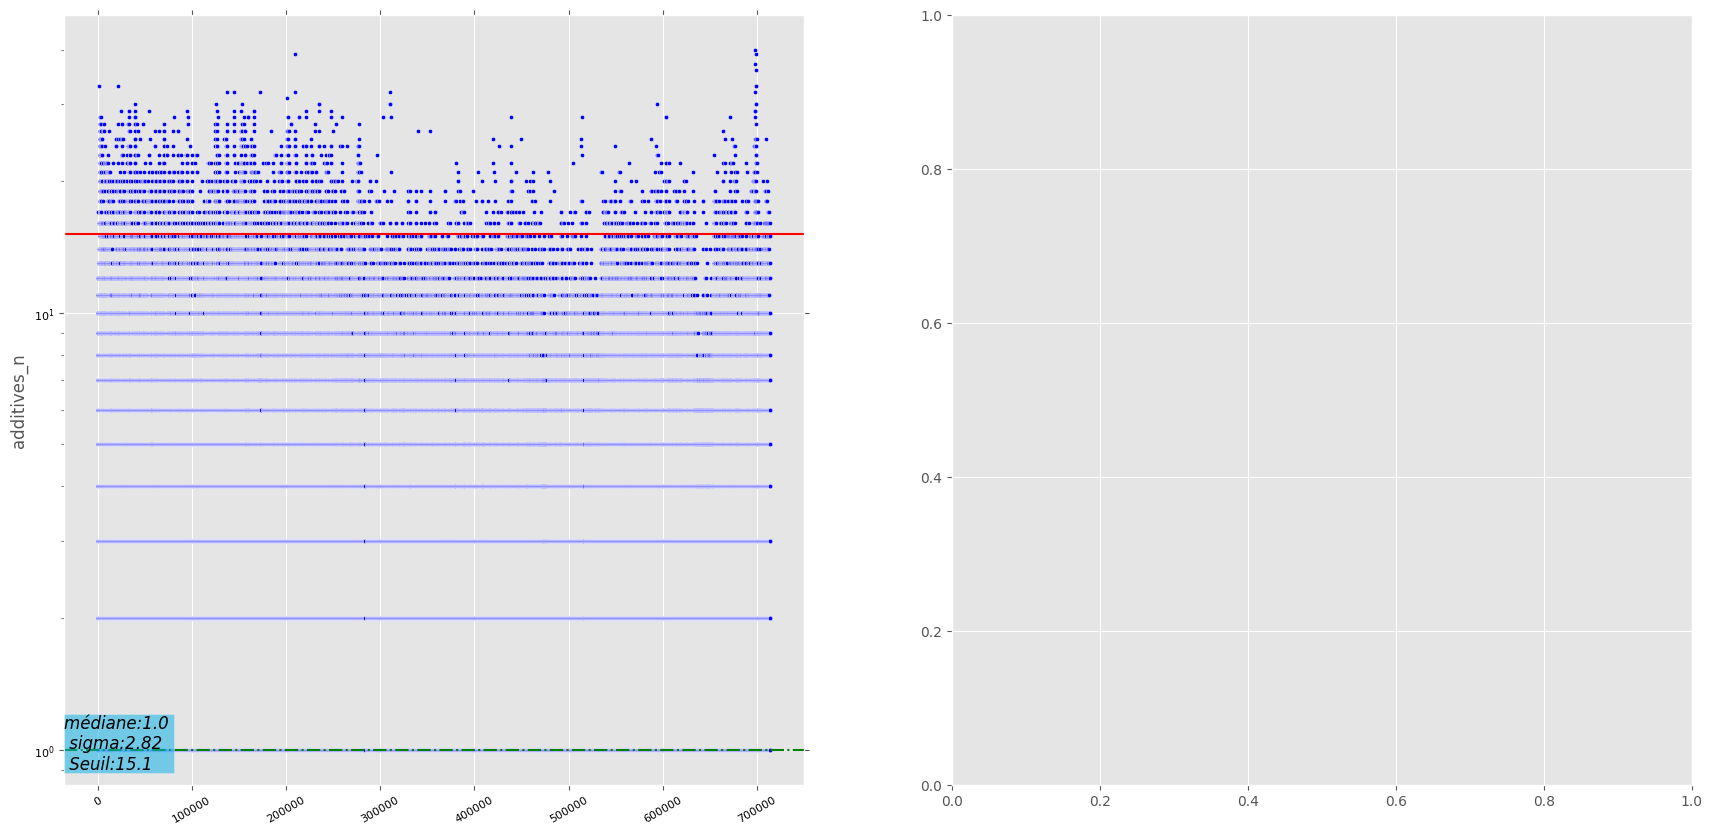

In [61]:
plt.style.use('ggplot')
tPlot, axes = plt.subplots(nrows=1, ncols=2, sharex=False, sharey=False, figsize=(21,10))
axes = np.array(axes)

i=0
for ax in axes.reshape(-1):
    colonne = sigma_features[i]
    test = datas_cleaned[pd.notnull(datas_cleaned[colonne])][colonne]
    ax.tick_params(labelcolor='black',top='off',bottom='on',left='on',right='off',labelsize=8)
    ax.set_ylabel(colonne.rstrip("_100g"), fontsize = 12)
    ax.set_yscale("log")
    ax.plot(list(test), 'b.', markeredgewidth = 0.3, markeredgecolor='w')
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    ax.axhline(y=median[i], color='g', linestyle='dashdot')
    ax.axhline(y=median[i] + 5*sigma[i], color='r', linestyle='-')
    ax.text(0., 0.02, 'médiane:{:.3} \n sigma:{:.3} \n Seuil:{:.3}'.format(median[i], sigma[i], (median[i] + 5*sigma[i])),
            style='italic', transform=ax.transAxes, fontsize = 12,
            bbox={'facecolor':'#00afe6', 'alpha':0.5, 'pad':0})
    i += 1

tPlot.text(0.5, 1.01, r"Dispersion des données nutritionnelles" "\n" "Visualisation des outliers", ha='center', fontdict=font_title)
plt.tight_layout()

Ces représentations nous indiquent clairement les éventuels **outliers qui diffèrent de la valeur médiane de plus de 5 fois l'écart-type ($5\sigma$ - valeur sélectionnée après plusieurs essais)**.

In [62]:
for i in range(len(sigma_features)):
    col = sigma_features[i]
    threshold = (median[i] + 5*sigma[i])
    print('{:30}: suppression de la ligne si valeur > {}'.format(col, round(threshold,3)))
    mask = datas_cleaned[col] > threshold
    datas_cleaned = datas_cleaned.drop(datas_cleaned[mask].index)

additives_n                   : suppression de la ligne si valeur > 15.115


In [63]:
datas_cleaned.shape

(1847864, 39)

In [64]:
datas_cleaned.describe()

completeness   energy_100g  proteins_100g  carbohydrates_100g   
count  1.847862e+06  1.744319e+06   1.734405e+06        1.732747e+06  \
mean   4.811868e-01  1.111500e+03   8.548569e+00        2.906133e+01   
std    2.018409e-01  7.732547e+02   1.014596e+01        2.784540e+01   
min    2.000000e-01  0.000000e+00   0.000000e+00        0.000000e+00   
25%    3.000000e-01  4.180000e+02   1.315789e+00        4.300000e+00   
50%    4.000000e-01  1.067000e+03   6.000000e+00        1.730000e+01   
75%    5.750000e-01  1.661000e+03   1.200000e+01        5.360000e+01   
max    1.100000e+00  3.700000e+03   1.000000e+02        1.000000e+02   

           fat_100g   sugars_100g  energy-kcal_100g  saturated-fat_100g   
count  1.731931e+06  1.713474e+06      1.701922e+06        1.692226e+06  \
mean   1.293768e+01  1.325329e+01      2.661998e+02        4.797596e+00   
std    1.622484e+01  1.937280e+01      1.850076e+02        7.336047e+00   
min    0.000000e+00  0.000000e+00      0.000000e+00        0.000000e+00   
25%    7.000000e-01  7.000000e-01      1.000000e+02        1.000000e-01   
50%    6.700000e+00  3.700000e+00      2.560000e+02        1.700000e+00   
75%    2.035398e+01  1.803000e+01      3.972222e+02        6.670000e+00   
max    1.000000e+02  1.000000e+02      9.000000e+02        1.000000e+02   

          salt_100g   sodium_100g     fiber_100g  nutrition-score-fr_100g   
count  1.549297e+06  1.549295e+06  788691.000000            744290.000000  \
mean   1.376205e+00  5.504858e-01       3.359076                 9.143806   
std    4.631041e+00  1.852462e+00       5.985402                 8.680699   
min    0.000000e+00  0.000000e+00       0.000000               -15.000000   
25%    1.000000e-01  4.000000e-02       0.000000                 2.000000   
50%    5.833333e-01  2.333333e-01       1.700000                10.000000   
75%    1.400000e+00  5.600000e-01       3.900000                16.000000   
max    1.000000e+02  4.000000e+01     100.000000                40.000000   

       nutriscore_score  unique_scans_n    additives_n   
count     744287.000000   638946.000000  711166.000000  \
mean           9.143779        2.556826       1.893036   
std            8.680703        6.817592       2.598862   
min          -15.000000        1.000000       0.000000   
25%            2.000000        1.000000       0.000000   
50%           10.000000        1.000000       1.000000   
75%           16.000000        2.000000       3.000000   
max           40.000000      842.000000      15.000000   

       fruits-vegetables-nuts-estimate-from-ingredients_100g     nova_group  
count                                      711910.000000      629859.000000  
mean                                            8.693966           3.394017  
std                                            33.747978           0.986876  
min                                             0.000000           1.000000  
25%                                             0.000000           3.000000  
50%                                             0.000000           4.000000  
75%                                             1.200000           4.000000  
max                                         13461.000000           4.000000

Après ces quelques opérations de nettoyage, les valeurs médianes, d'écarts-type, de minimum et maximum sont plus cohérentes. Nous allons pouvoir exploiter ces données pour **estimer les valeurs manquantes**.

Nous allons déjà regarder la **distribution de ces variables et définir si elles suivent une loi normale**, ce qui nous aidera à prendre une décision pour la méthode d'imputation des valeurs manquantes.

ValueError: num must be an integer with 1 <= num <= 12, not 13

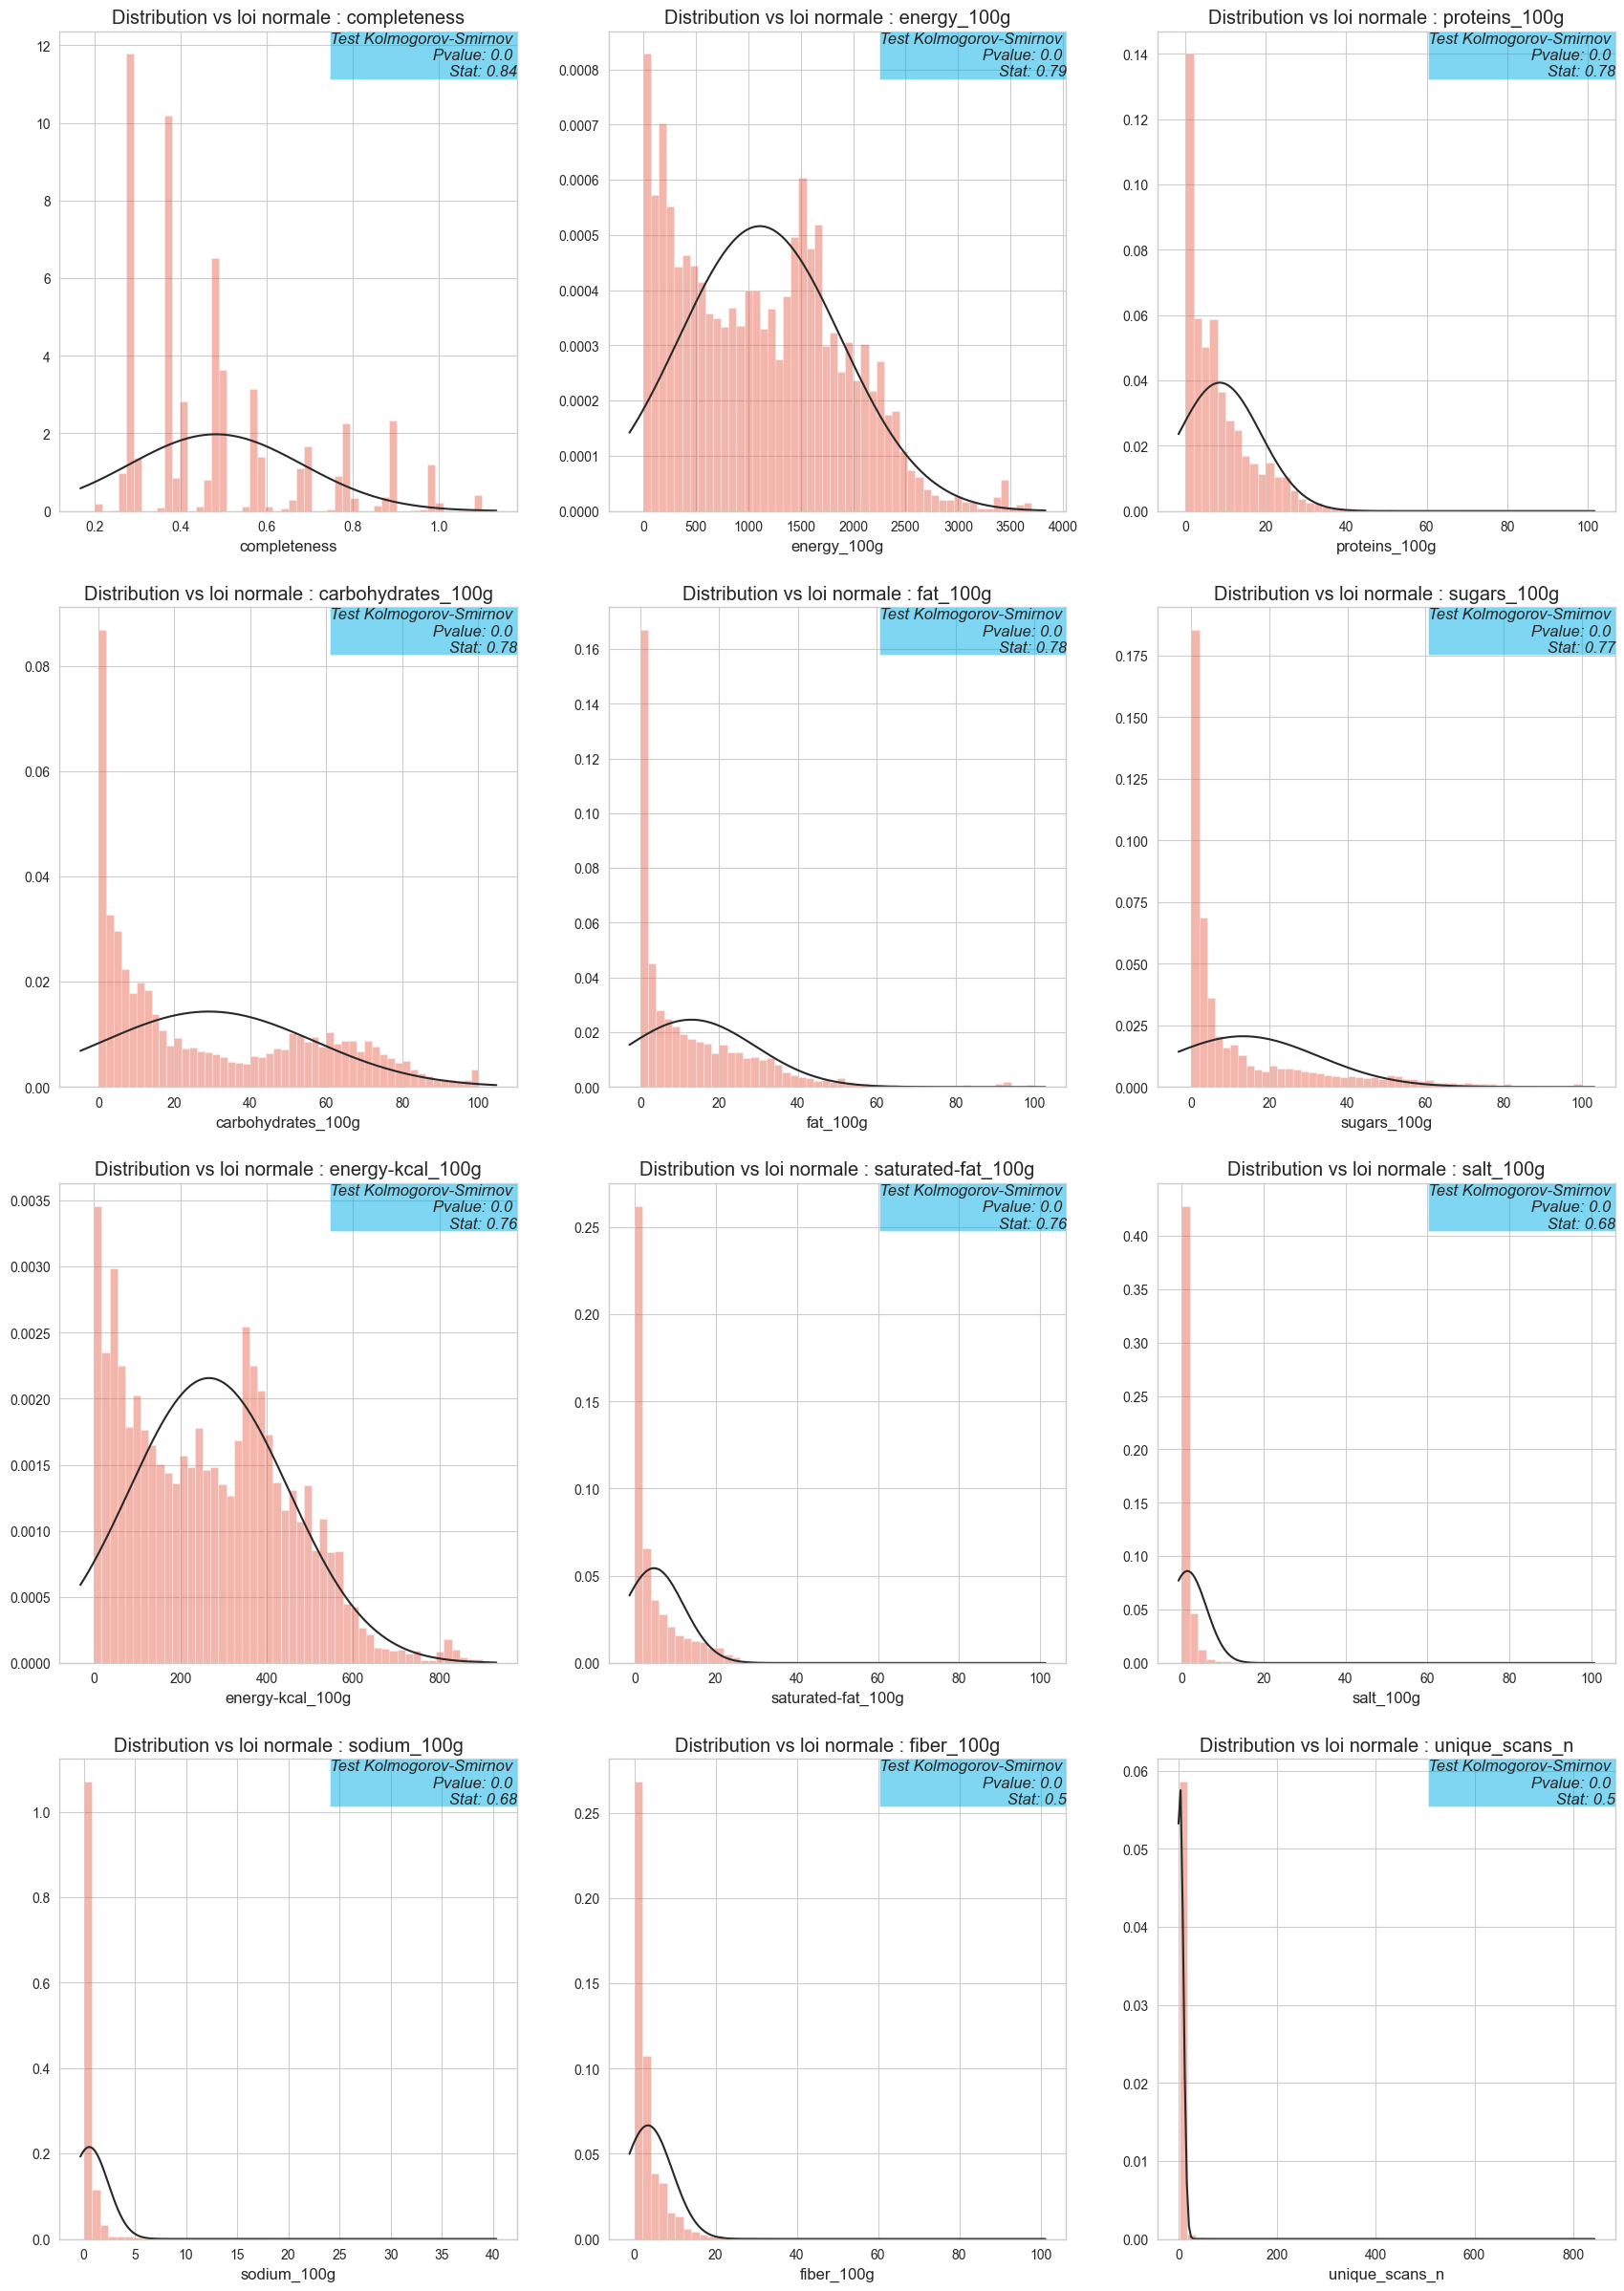

In [65]:
import scipy.stats as stats
import warnings

warnings.filterwarnings('ignore')
sns.set_style("whitegrid")
fig = plt.figure(figsize=(21, 30))

sub = 0
for i in range(len(numerical_features)):
    colonne = numerical_features[i]
    if datas_cleaned[colonne].nunique() > 1:
        # Tracé de la distribution
        fig.add_subplot(4, 3, sub+1)

        left, width = 0, 1
        bottom, height = 0, 1
        right = left + width
        top = bottom + height

        kstest = stats.kstest(datas_cleaned[colonne].notnull(), 'norm')
        ax = sns.distplot(datas_cleaned[colonne], fit=stats.norm, kde=False)
        ax.set_title("Distribution vs loi normale : {}".format(colonne))
        ax.text(right, top, 'Test Kolmogorov-Smirnov \n Pvalue: {:.2} \n Stat: {:.2}'.format(kstest.pvalue, kstest.statistic),
                horizontalalignment='right',
                verticalalignment='top',
                style='italic', transform=ax.transAxes, fontsize=12,
                bbox={'facecolor': '#00afe6', 'alpha': 0.5, 'pad': 0})
        sub += 1
    else:
        print("La colonne {} ne contient pas suffisamment de données pour être tracée.".format(colonne))

plt.show()


En se basant sur les projections obtenus et les résultats des tests de Kolmogorov-Smirnov (Pvalue < au niveau de test de 5%) **on rejette donc l'hypothèse de normalité des distributions de ces variables**. Il serait donc inexacte d'imputer les valeurs manquantes par la moyenne.

Pour confirmer cette approche, regardons à présent quelque unes de ces distributions en fonction de la catégorie `pnns_groups_1` :

ValueError: num must be an integer with 1 <= num <= 12, not 13

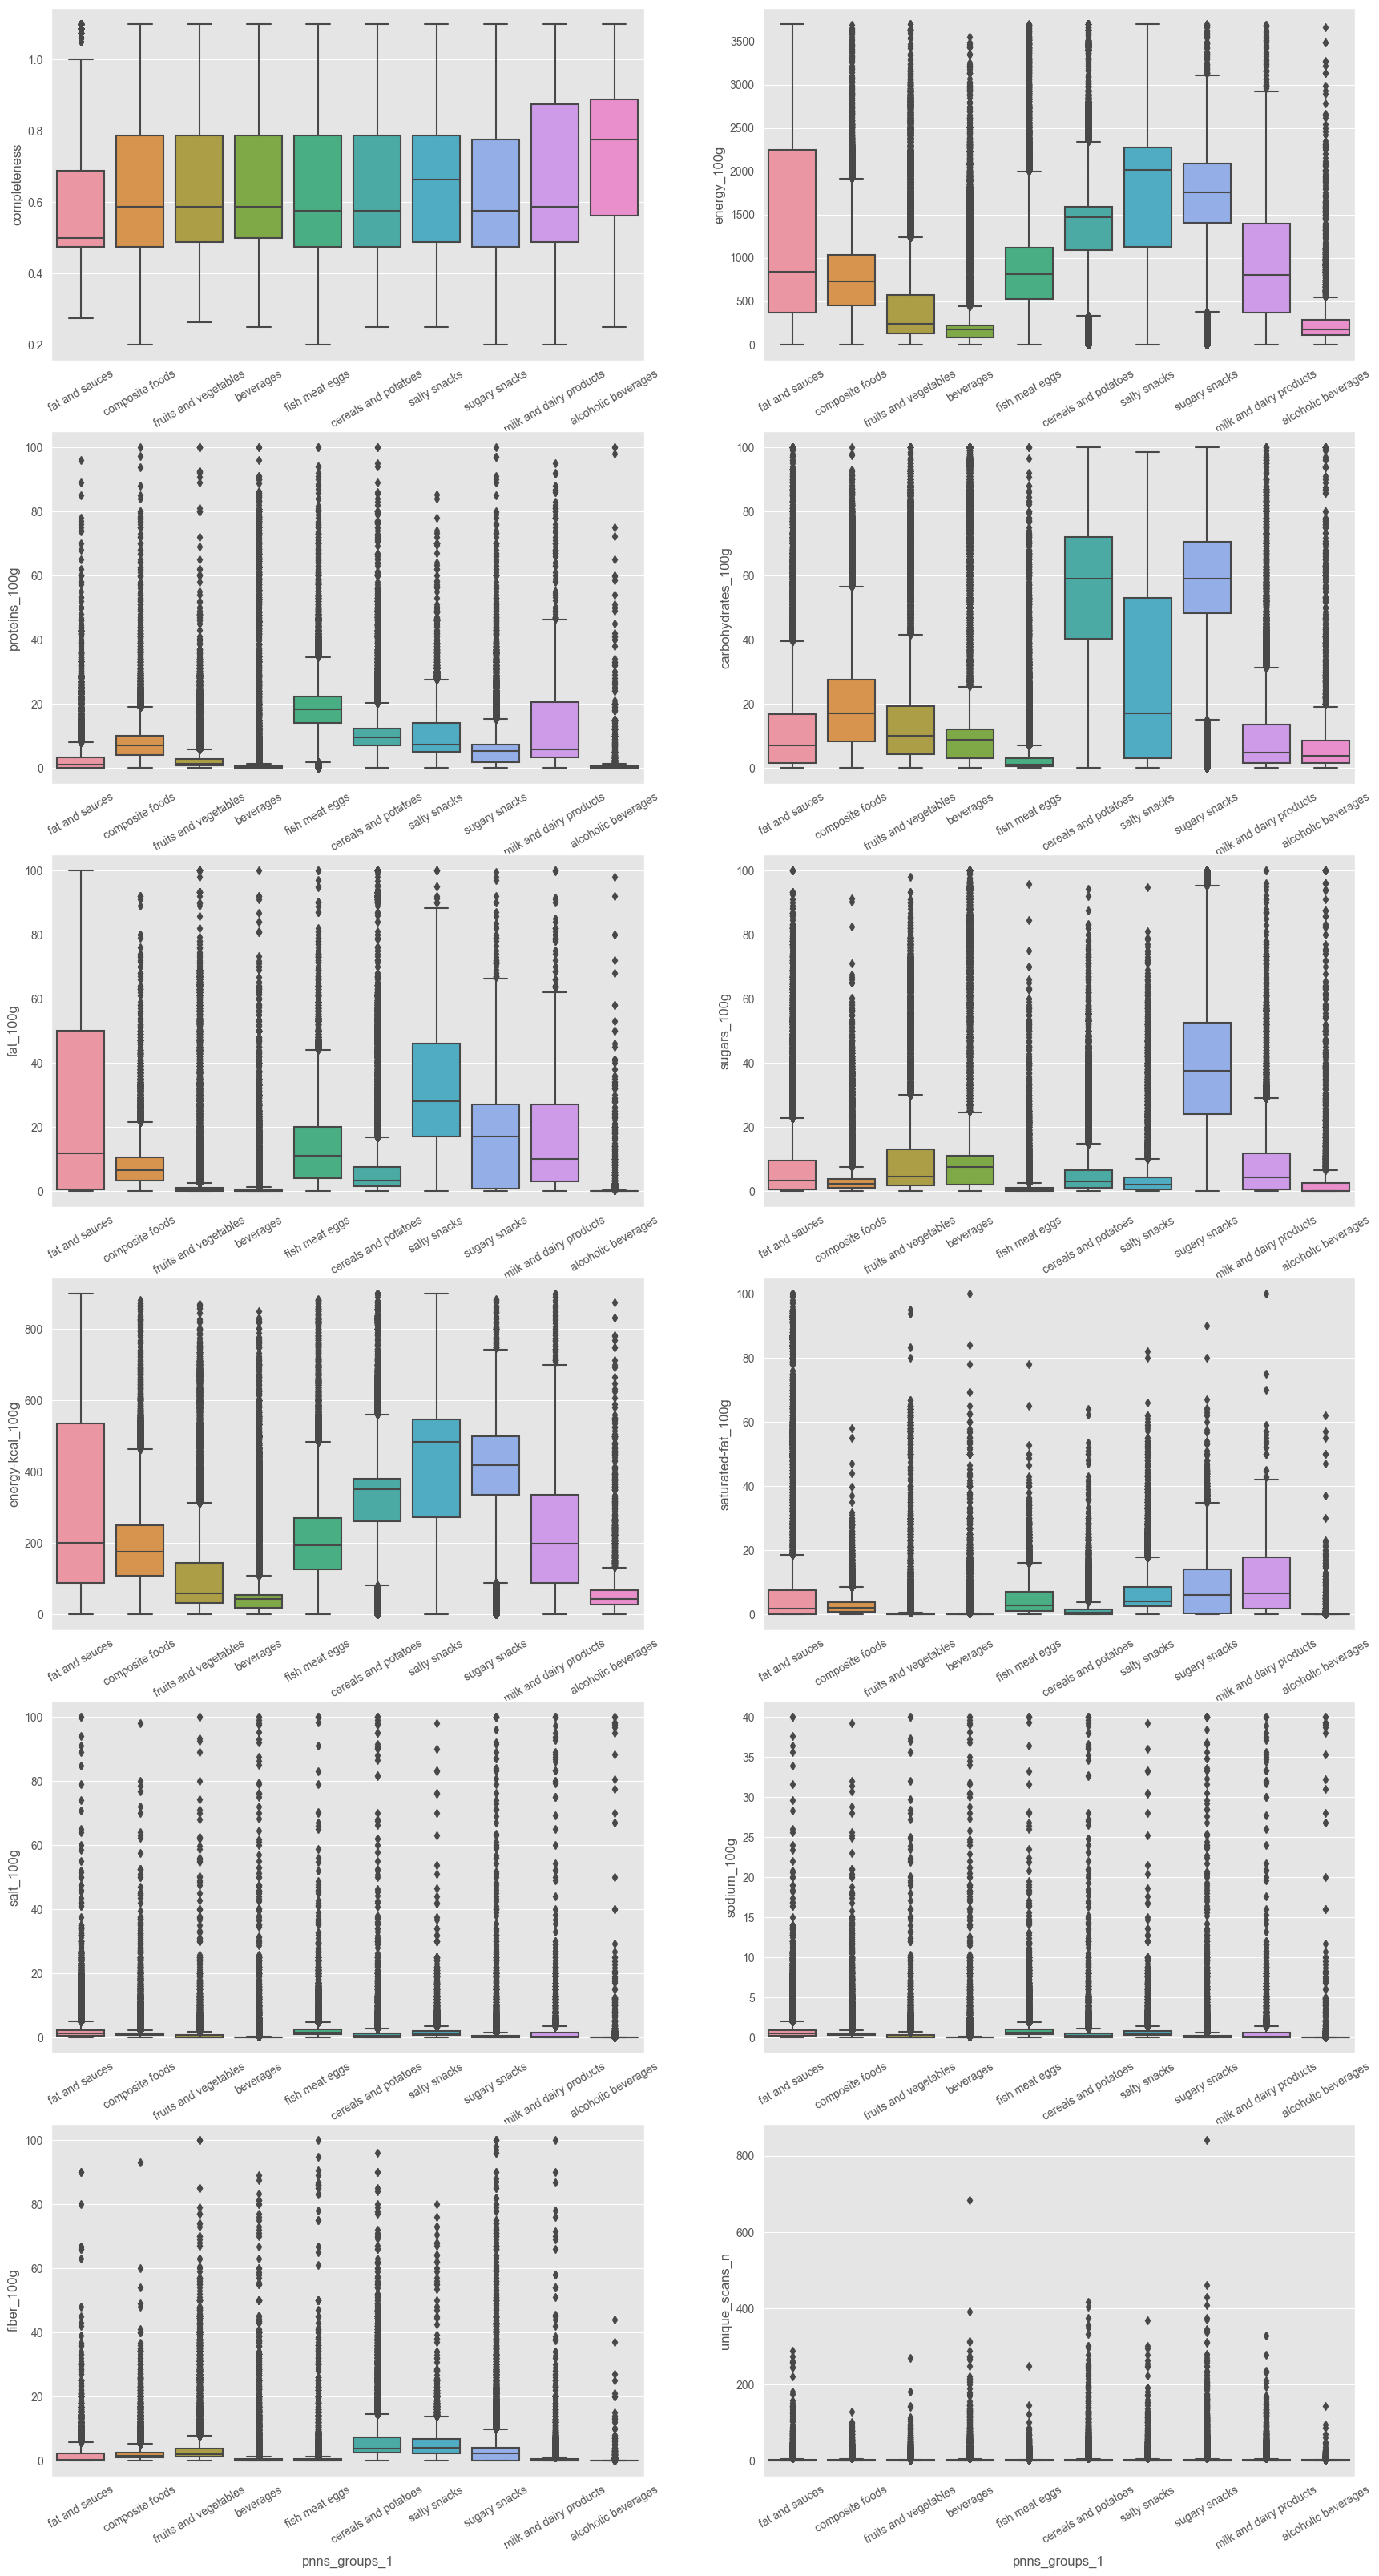

In [66]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,40))

sub = 0
for i in range(len(numerical_features)):
    fig.add_subplot(6,2,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(x="pnns_groups_1", y=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_1"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_1", ha="center", 
         fontdict=font_title)
plt.show()

Si l'on regarde la distribution de quelques unes de ces mêmes variables sur la catégorie `pnns_groups_2` :

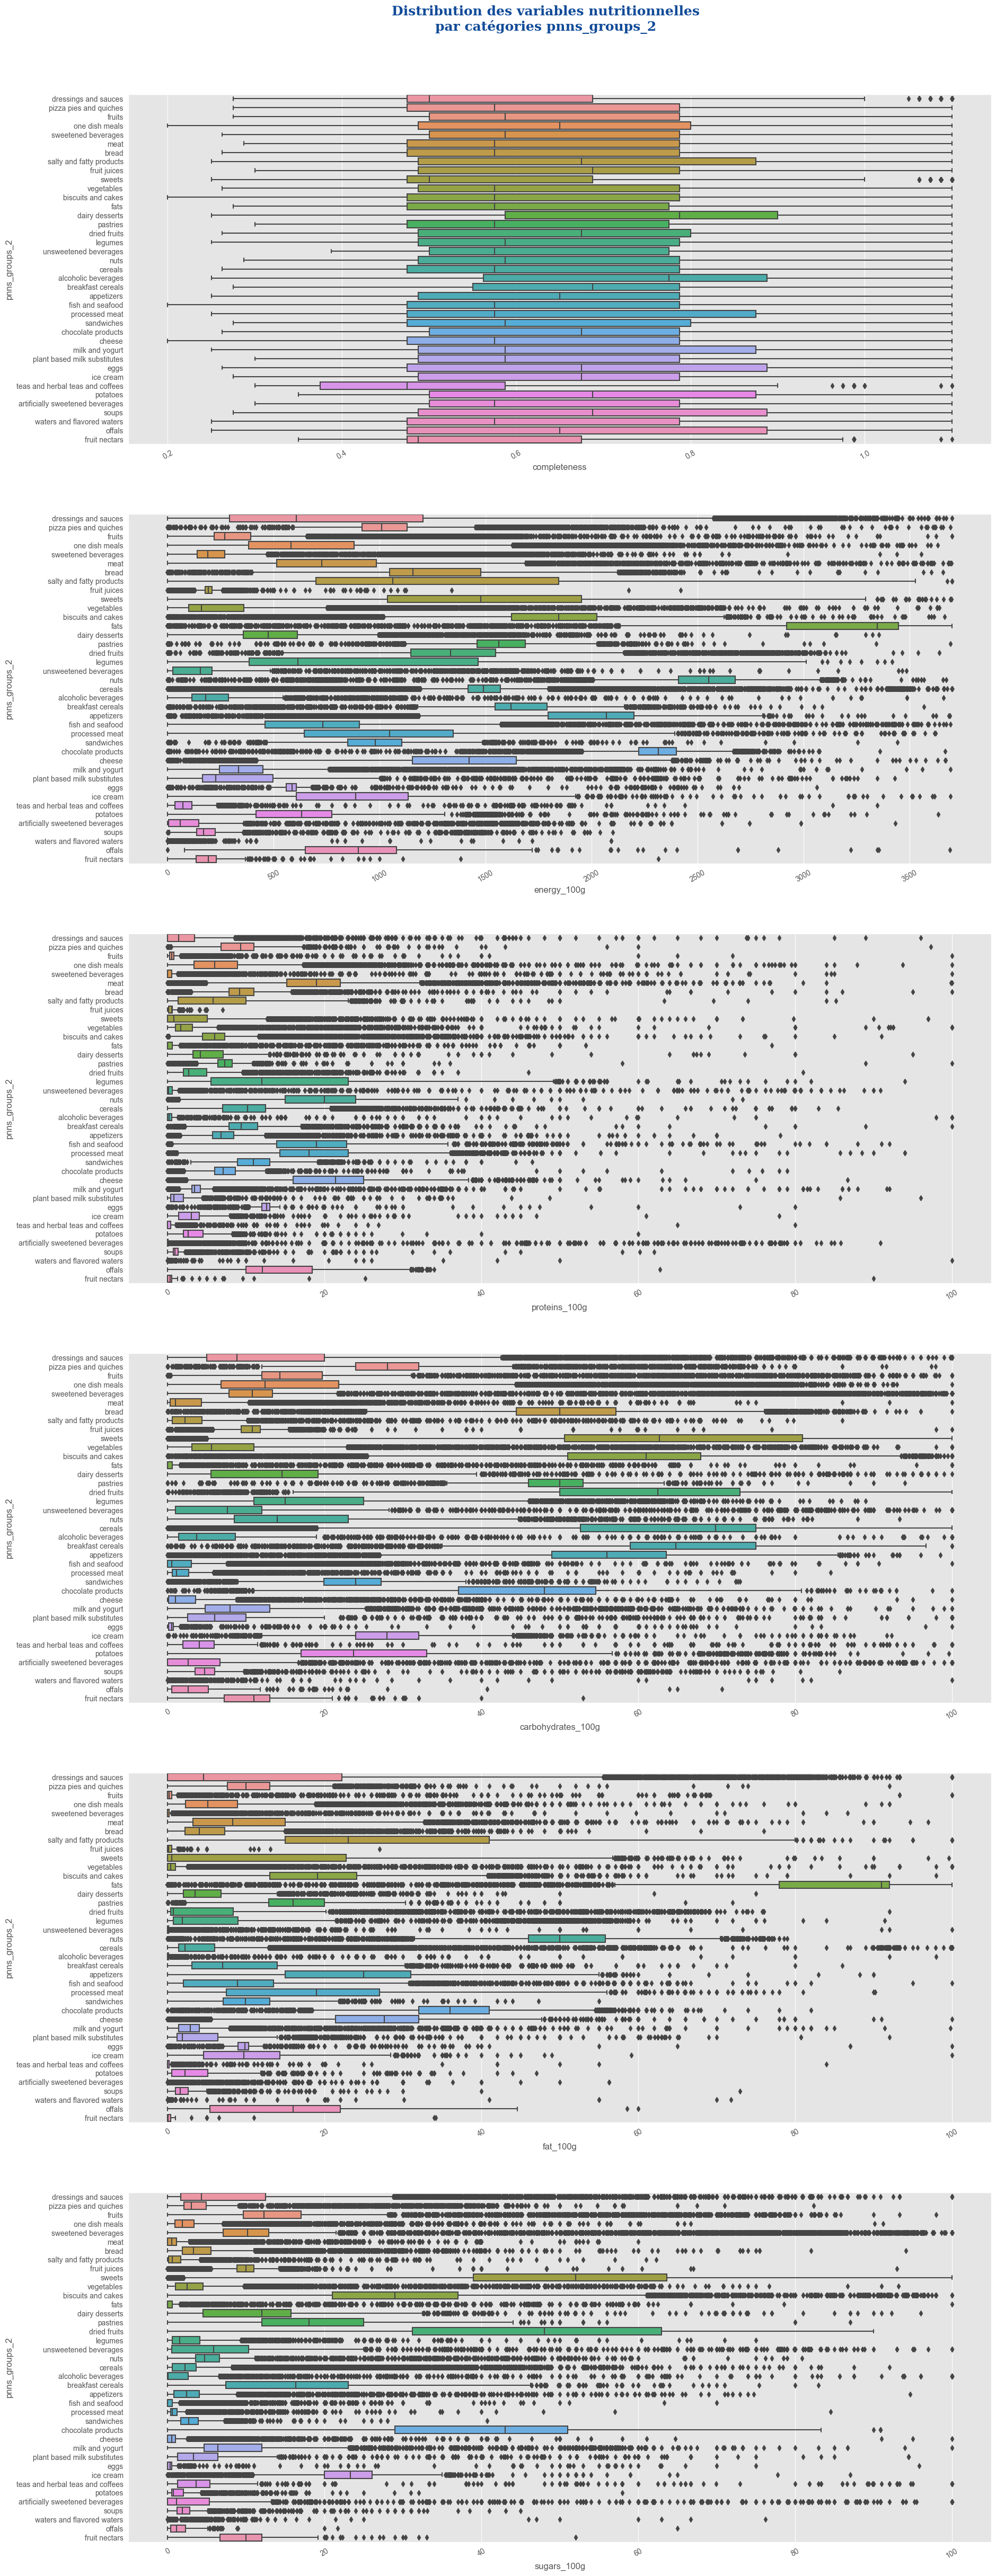

In [67]:
plt.style.use('ggplot')
fig = plt.figure(figsize=(21,60))

sub = 0
for i in range(len(numerical_features[:6])):
    fig.add_subplot(6,1,i+1)
    colonne = numerical_features[i]
    ax = sns.boxplot(y="pnns_groups_2", x=colonne, data=datas_cleaned[datas_cleaned["pnns_groups_2"]!="unknown"])
    for tick in ax.get_xticklabels():
        tick.set_rotation(30)
    sub += 1

fig.text(0.5, 0.90, r"Distribution des variables nutritionnelles" "\n" "par catégories pnns_groups_2", ha="center", 
         fontdict=font_title)
plt.show()

In [68]:
datas_cleaned[numerical_features].isnull().sum()

completeness                                                   2
energy_100g                                               103545
proteins_100g                                             113459
carbohydrates_100g                                        115117
fat_100g                                                  115933
sugars_100g                                               134390
energy-kcal_100g                                          145942
saturated-fat_100g                                        155638
salt_100g                                                 298567
sodium_100g                                               298569
fiber_100g                                               1059173
unique_scans_n                                           1208918
additives_n                                              1136698
fruits-vegetables-nuts-estimate-from-ingredients_100g    1135954
dtype: int64

Pour ces valeurs nulles ci-dessus, les variables `serving_quantity` et `additives_n` sont très peu renseignées, nous allons donc les supprimer de notre jeu de données.     
`fiber_100g` est également mal renseigné mais nous en aurons besoin pour la suite. Nous allons donc compléter les valeurs nulles par la **médiane de la catégorie** `pnns_groups_2`.     
Enfin, pour les autres variables, avec peu de null et dont les distributions ne suivent pas la loi gaussiene, nous allons imputer avec l'**algorithme des K Nearest Neighbours** (KNN).

In [70]:
#On supprime les 2 colonnes les moins complétées et la variable redondante energie
datas_cleaned.drop(['additives_n','energy-kcal_100g'], axis=1, inplace=True)

In [ ]:
#numerical_features.remove('serving_quantity')
numerical_features.remove('additives_n')
numerical_features.remove('energy-kcal_100g')

In [72]:
# KNN pour les autres variables
from sklearn.impute import KNNImputer

# On entraine le modèle d'imputation sur un échantillon de données
knn_features = ['energy_100g','proteins_100g','saturated-fat_100g','sugars_100g','salt_100g']
sample_datas = datas_cleaned[knn_features].sample(frac=0.25, random_state=1)
imputer = KNNImputer(n_neighbors=5, missing_values=np.nan)
imputer.fit(sample_datas)

KNNImputer()

In [ ]:
# Puis on applique le modèle sur l'ensemble des données
datas_imputed = imputer.transform(datas_cleaned[knn_features])
df_datas_imputed = pd.DataFrame(datas_imputed, columns=knn_features)

In [ ]:
for col_knn in knn_features:
    datas_cleaned[col_knn] = df_datas_imputed[col_knn].values

In [ ]:
# On complète les variables restantes avec la médiane du groupe pnns 2
for col in ['carbohydrates_100g','sodium_100g','fat_100g','fiber_100g']:
    datas_cleaned[col] = datas_cleaned.groupby('pnns_groups_2')[col].transform(lambda x: x.fillna(x.median()))

Les valeurs manquantes étant à présent toutes complétées pour ces variables numériques, nous allons vérifier que les distributions n'ont pas changées :

In [ ]:
sns.set_style("whitegrid")
fig = plt.figure(figsize=(21,20))

sub = 0
for i in range(len(numerical_features)):
    colonne = numerical_features[i]
    if datas_cleaned[colonne].notnull().sum() > 1:  # Vérifie qu'il y a au moins 2 données non manquantes
        fig.add_subplot(3,3,sub+1)
        kstest = stats.kstest(datas_cleaned[colonne].notnull(),'norm')
        ax = sns.kdeplot(datas_cleaned[colonne].dropna(), shade=True)
        ax.set_title("Distribution vs loi normale : {}".format(colonne))
        sub += 1

plt.show()


Les variables imputées étant bien distribuées conformément aux variables d'origine, nous allons à présent **supprimer les dernières variables non pertinentes**, peu renseignées ou inutiles dans nos futurs modèles :

In [ ]:
datas_cleaned.isnull().sum().sort_values(ascending=False)

In [ ]:
deleted_features = ['brands','serving_size','nova_group','image_ingredients_small_url','ingredients_text','image_nutrition_small_url','image_small_url', 'nutrition-score-fr_100g','quantity']
datas_cleaned.drop(deleted_features, axis=1, inplace=True)

### <font color="#ea1c60" id="section_6">1.6. Calcul des Nutri-Scores manquants</font>

Une des variables primoridale de ce jeu de données est le Nutriscore. Or, cette variable compte beaucoup de manquants. 
Afin de calculer ce nutriscore, nous avons besoin de plusieurs autres variables.

Le score prend en comptepour 100g de produit, la teneur :
- En nutriments et aliments à favoriser (fibres, protéines, fruits et légumes),
- En nutriments à limiter (énergie, acide gras saturés, sucres, sel).

Après calcul, le score obtenu par un produit permet de lui attribuer une lettre et une couleur.
Voici un tableau simplifié permettant de calculer l'attribution des points :

<table width="100%" style="border:solid 1px; text-align:center;" align="center">
    <thead style="border:solid 1px; text-align:center;">
        <th bgcolor="#feadb3"><b>Points</b></th>
        <th bgcolor="#feadb3">Energie (kJ)</th>
        <th bgcolor="#feadb3">Sucres simples (g)</th>
        <th bgcolor="#feadb3">Acide gras saturés (g)</th>
        <th bgcolor="#feadb3">Sodium (mg)</th>
        <th bgcolor="#b6faa3"><b>Points</b></th>
        <th bgcolor="#b6faa">Fruits,leg(%)</th>
        <th bgcolor="#b6faa">Fibres (g)</th>
        <th bgcolor="#b6faa">Protéines (g)</th>
    </thead>
    <tbody>
        <tr>
            <td bgcolor="#feadb3"><b>0</b></td>
            <td bgcolor="#feadb3">$\leq$ 335</td>
            <td bgcolor="#feadb3">$\leq$ 4,5</td>
            <td bgcolor="#feadb3">$\leq$ 1</td>
            <td bgcolor="#feadb3">$\leq$ 90</td>
            <td bgcolor="#b6faa"><b>0</b></td>
            <td bgcolor="#b6faa">$\leq$ 40</td>
            <td bgcolor="#b6faa">$\leq$ 0,7</td>
            <td bgcolor="#b6faa">$\leq$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>5</b></td>
            <td bgcolor="#feadb3">$>$ 335</td>
            <td bgcolor="#feadb3">$>$ 4,5</td>
            <td bgcolor="#feadb3">$>$ 1</td>
            <td bgcolor="#feadb3">$>$ 90</td>
            <td bgcolor="#b6faa"><b>-2</b></td>
            <td bgcolor="#b6faa">$>$ 40</td>
            <td bgcolor="#b6faa">$>$ 0,7</td>
            <td bgcolor="#b6faa">$>$ 1,6</td>
        </tr>
        <tr>
            <td bgcolor="#feadb3"><b>10</b></td>
            <td bgcolor="#feadb3">$>$ 1675</td>
            <td bgcolor="#feadb3">$>$ 22,5</td>
            <td bgcolor="#feadb3">$>$ 5</td>
            <td bgcolor="#feadb3">$>$ 450</td>
            <td bgcolor="#b6faa"><b>-5</b></td>
            <td bgcolor="#b6faa">$>$ 80</td>
            <td bgcolor="#b6faa">$>$ 3,5</td>
            <td bgcolor="#b6faa">$>$ 8</td>
        </tr>
        <tr style="border:solid 1px; text-align:center;">
            <td> </td>
            <td>(a)</td>
            <td>(b)</td>
            <td>(c)</td>
            <td>(d)</td>
            <td> </td>
            <td>(e)</td>
            <td>(f)</td>
            <td>(g)</td>
        </tr>
        <tr>
            <td><b>Total</b></td>
            <td colspan="8"><b>(a) + (b) + (c) + (d) + (e) + (f) + (g)</b></td>
        </tr>
    </tbody>
</table>

Attribution des classes *(version simplifiée)* :

<table width="50%" style="border:solid 1px; text-align:center;" align="center">
    <thead>
        <th>Aliment solide</th>
        <th>Lettre</th>
        <th>Couleur</th>
    </thead>
    <tbody>
        <tr>
            <td>Mimimum -1</td>
            <td>A</td>
            <td>Vert foncé</td>
        </tr>
        <tr>
            <td>0 à 5</td>
            <td>B</td>
            <td>Vert</td>
        </tr>
        <tr>
            <td>5 à 10</td>
            <td>C</td>
            <td>Jaune</td>
        </tr>
        <tr>
            <td>10 à 20</td>
            <td>D</td>
            <td>Orange</td>
        </tr>
        <tr>
            <td>20 et plus</td>
            <td>E</td>
            <td>Orange foncé</td>
        </tr>
    </tbody>
</table>

Nous allons donc **isoler les variables nécessaires au calcul du Nutriscore et vérifier leur taux de remplissage** :

In [ ]:
nutriscore_features = ['pnns_groups_1', 'pnns_groups_2', 'nutriscore_grade', 'nutriscore_score',
                       'energy_100g','sugars_100g','saturated-fat_100g','sodium_100g', 'fiber_100g', 'proteins_100g']
datas_cleaned[nutriscore_features].sample(10)

La variable indiquant la proportion de fruit/légumes des produits a été supprimée car très peu renseignée. Nous allons donc tenter de l'estimer en fonction de la catégorie :

In [ ]:
datas_cleaned.pnns_groups_2.unique()

In [ ]:
high_rate_fruit = ['fruit juices','dried fruits','legumes','vegetables','fruits', 'soups','potatoes','fruit nectars']

medium_rate_fruit = ['unknown', 'sweetened beverages', 'dressings and sauces', 'ice cream', 'pastries', 'dairy desserts',
                     'pizza pies and quiche', 'pizza pies and quiches']

low_rate_fruit = ['waters and flavored waters','chocolate products', 'fish and seafood', 'salty and fatty products', 
                  'cheese', 'cereals', 'appetizers', 'one dish meals', 'bread', 'fats', 'plant based milk substitutes',
                  'alcoholic beverages', 'processed meat', 'breakfast cereals', 'meat', 'eggs', 'sandwiches',
                  'offals', 'teas and herbal teas and coffees', 'biscuits and cakes', 'sweets', 'milk and yogurt',
                  'artificially sweetened beverages', 'unsweetened beverages','nuts']

In [ ]:
datas_cleaned['fruits-vegetables-rate_100g'] = [81 if cat in high_rate_fruit else 45 if cat in medium_rate_fruit else 25 for cat in datas_cleaned.pnns_groups_2]

A présent, nous allons définir la **fonction de calcul du Nutriscore** et l'appliquer à notre dataset :

In [ ]:
def calc_globalscore(row):
    #Energy
    if row["energy_100g"] <= 335:
        a = 0
    elif ((row["energy_100g"] > 335) & (row["energy_100g"] <= 1675)):
        a = 5
    else:
        a = 10 
    #Sugar
    if row["sugars_100g"] <= 4.5:
        b = 0
    elif ((row["sugars_100g"] > 4.5) & (row["sugars_100g"] <= 22.5)):
        b = 5
    else:
        b = 10
    #saturated-fat
    if row["saturated-fat_100g"] <= 1:
        c = 0
    elif ((row["saturated-fat_100g"] > 1) & (row["saturated-fat_100g"] <= 5)):
        c = 5
    else:
        c = 10
    #sodium
    if (row["sodium_100g"]/1000) <= 90:
        d = 0
    elif (((row["sodium_100g"]/1000) > 90) & ((row["sodium_100g"]/1000) <= 450)):
        d = 5
    else:
        d = 10
    #fruits-vegetables-rate
    if row["fruits-vegetables-rate_100g"] <= 40:
        e = 0
    elif ((row["fruits-vegetables-rate_100g"] > 40) & (row["fruits-vegetables-rate_100g"] <= 80)):
        e = -2
    else:
        e = -5
    #fiber
    if row["fiber_100g"] <= 0.7:
        f = 0
    elif ((row["fiber_100g"] > 0.7) & (row["fiber_100g"] <= 3.5)):
        f = -2
    else:
        f = -5
    #proteins
    if row["proteins_100g"] <= 1.6:
        g = 0
    elif ((row["proteins_100g"] > 1.6) & (row["proteins_100g"] <= 8)):
        g = -2
    else:
        g = -5
    
    #Global_score
    global_score = a+b+c+d+e+f+g
    
    return global_score

In [ ]:
#Nutriscore
def calc_nutriscore(row):
    if row["calc_global_score"] < 0 :
        nutriscore = "a"
    elif ((row["calc_global_score"] >= 0) & (row["calc_global_score"] < 5)) :
        nutriscore = "b"
    elif ((row["calc_global_score"] >= 5) & (row["calc_global_score"] < 10)) :
        nutriscore = "c"
    elif ((row["calc_global_score"] >= 10) & (row["calc_global_score"] < 20)) :
        nutriscore = "d"
    else:
        nutriscore = "e"
        
    return nutriscore

In [ ]:
datas_cleaned['calc_global_score'] = datas_cleaned.apply(lambda row: calc_globalscore(row),axis=1)
datas_cleaned['calc_nutriscore'] = datas_cleaned.apply(lambda row: calc_nutriscore(row),axis=1)

In [ ]:
nutriscore_features.append('calc_global_score')
nutriscore_features.append('calc_nutriscore')

In [ ]:
datas_cleaned[nutriscore_features].sample(10)

Nous devons à présent **vérifier les erreurs d'imputation sur les scores déjà connus**, ce qui nous permettra de voir si les calculs sont satisfaisants et utilisables :

In [ ]:
df_scores = datas_cleaned[['nutriscore_grade', 'nutriscore_score', 'calc_nutriscore', 'calc_global_score']][datas_cleaned['nutriscore_grade'].isnull()==False]

from sklearn.metrics import accuracy_score

accuracy_nutrigrade = accuracy_score(df_scores['nutriscore_grade'].values, df_scores['calc_nutriscore'].values)
print("L'accuracy_score sur les Nutrigrades calculés est de : {:.2f} %.".format(accuracy_nutrigrade*100))

La précision du calul est donc inférieure à 50%. **Ces calculs ne peuvent donc pas être utilisés pour compléter nos données**.     **<font color="green">Notre application aura donc pour but d'éstimer le nutrigrade d'un produit en fonction de ses caractéristiques connues, comme la catégorie, sa teneur en nutriments ... grâce à des algorithmes simples de Machine Learning</font>**. 

In [ ]:
datas_cleaned.drop(['calc_nutriscore','calc_global_score'], axis=1, inplace=True)

In [ ]:
datas_cleaned.info()

Les variables sont à présent filtrées et les données nettoyées et complétées. Nous allons sauvegarder le dataset cleaned pour l'utiliser à présent dans nos **analyses exploratoires**.

In [ ]:
datas_cleaned.set_index("code").to_csv("cleaned_openfoodfacts.csv", sep='\t')

In [ ]:
pd.set_option('display.max_columns', None)
datas_cleaned